# 資金繰りリスク可視化ツール
**中小企業向け キャッシュフロー・リスク分析システム**

---

## 使い方
1. **セル1**: ライブラリ読み込み（変更不要）
2. **セル2〜3**: クラス・関数の定義（変更不要）
3. **セル4**: ★ここだけ編集★ 会社の数字を入力
4. **セル5以降**: 上から順に実行

> 「上のセルから順番に実行する」が基本ルールです。  
> `Shift + Enter` で1セルずつ実行できます。

---

| Phase | 内容 | セル |
|-------|------|------|
| Phase 1 | 基本シミュレーション・感度分析 | 1〜8 |
| Phase 2 | ストレステスト（売上急落・取引先倒産・金利上昇・仕入高騰） | 9〜13 |
| Phase 3 | 改善策提案エンジン（業種別AR・資金調達オプション） | 14〜18 |


In [1]:
# ============================================================
# セル1: ライブラリのインポートと初期設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import copy
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, List, Dict
from pathlib import Path

warnings.filterwarnings('ignore')

# ── 日本語フォントの自動検出 ──
def setup_japanese_font():
    import matplotlib.font_manager as fm
    candidates = ['MS Gothic', 'Yu Gothic', 'Meiryo', 'MS PGothic',
                  'BIZ UDGothic', 'IPAGothic', 'IPAPGothic']
    available = {f.name for f in fm.fontManager.ttflist}
    for font in candidates:
        if font in available:
            plt.rcParams['font.family'] = font
            print(f"✅ 日本語フォント設定: {font}")
            return font
    print("⚠️  日本語フォントが見つかりません。文字化けする場合があります。")
    return None

setup_japanese_font()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

# ── 出力フォルダの設定 ──
OUTPUT_DIR = Path.cwd()
print(f"✅ 出力フォルダ: {OUTPUT_DIR}")
print(f"✅ NumPy: {np.__version__}  /  Matplotlib: {plt.matplotlib.__version__}")


✅ 日本語フォント設定: MS Gothic
✅ 出力フォルダ: C:\Users\TSR\Desktop\CFMプログラム
✅ NumPy: 2.3.5  /  Matplotlib: 3.10.6


In [2]:
# ============================================================
# セル2: パラメータクラスと業種マスタの定義（変更不要）
# ============================================================

@dataclass
class CashFlowParameters:
    """
    資金繰りシミュレーションのパラメータ管理クラス。

    Parameters
    ----------
    monthly_sales        : 月次平均売上（万円）。過去3〜6ヶ月平均を入力。
    cash_balance         : 現在の現金・預金残高（万円）。今日時点の通帳残高。
    monthly_fixed_cost   : 月次固定費（万円）。家賃・人件費・リース等の合計。
    cost_rate            : 売上原価率（小数）。例: 60%なら0.60。
    sales_volatility     : 売上変動率（小数）。不明なら0.15のままでOK。
    accounts_receivable_days : 売掛サイト（日数）。売上が現金になるまでの日数。
    simulation_months    : シミュレーション期間（ヶ月）。
    num_simulations      : シミュレーション回数。多いほど精度UP。推奨10,000。
    """
    monthly_sales:            float
    cash_balance:             float
    monthly_fixed_cost:       float
    cost_rate:                float
    sales_volatility:         float = 0.15
    accounts_receivable_days: int   = 30
    simulation_months:        int   = 12
    num_simulations:          int   = 10000

    def validate(self):
        assert self.monthly_sales > 0,          "月次売上は0より大きい値を入力してください"
        assert self.cash_balance >= 0,           "現金残高は0以上を入力してください"
        assert self.monthly_fixed_cost >= 0,     "月次固定費は0以上を入力してください"
        assert 0 <= self.cost_rate <= 1,         "原価率は0〜1の範囲で入力してください（例: 60%→0.60）"
        assert 0 <= self.sales_volatility <= 1,  "売上変動率は0〜1の範囲で入力してください"
        assert 0 <= self.accounts_receivable_days <= 180, "売掛サイトは0〜180日で入力してください"
        assert 1 <= self.simulation_months <= 36, "シミュレーション期間は1〜36ヶ月で入力してください"
        print("✅ 入力値チェック完了")

    def gross_profit_rate(self):
        return 1.0 - self.cost_rate

    def monthly_gross_profit(self):
        return self.monthly_sales * self.gross_profit_rate()

    def monthly_net_cf(self):
        """月次純キャッシュフロー（平均）"""
        return self.monthly_gross_profit() - self.monthly_fixed_cost

    def breakeven_sales(self):
        """損益分岐点売上高（万円/月）"""
        return self.monthly_fixed_cost / self.gross_profit_rate()

    def safety_months(self):
        """現金残高が固定費何ヶ月分か"""
        return self.cash_balance / self.monthly_fixed_cost


# ── 業種別 売掛サイトマスタ ──
# 出典: T社データ・信金実務経験に基づく商慣行
INDUSTRY_AR_MASTER = {
    '建設業':             {'standard': 75, 'floor': 60,
        'note': '多重下請構造。元請の支払サイトに依存。個社努力での大幅短縮は困難。新規直接工事案件から交渉余地。'},
    '製造業':             {'standard': 52, 'floor': 45,
        'note': '系列・大企業主導。下請法の範囲内だが発注者が実質決定。新規・海外顧客は比較的短期化しやすい。'},
    'IT・システム開発':   {'standard': 37, 'floor': 30,
        'note': 'プロジェクト完了検収が起点。検収期間短縮が実質的な改善手段。新規SMB案件は翌月払い設定が通りやすい。'},
    '広告・マーケティング': {'standard': 75, 'floor': 60,
        'note': '代理店を挟む多段構造。最終広告主のサイトがそのまま転嫁。直接取引比率向上が根本的改善。'},
    '卸売・小売':         {'standard': 45, 'floor': 30,
        'note': 'サプライチェーン上の立場で変動大。大手バイヤーには交渉困難。小口・新規先は短期化余地あり。'},
    'EC・SaaS':          {'standard': 15, 'floor':  0,
        'note': 'デジタル決済で既に短期化済。クレカ・月次課金が標準。さらなる短縮より未回収リスク管理が重要。'},
    '医療・介護':         {'standard': 45, 'floor': 30,
        'note': '保険診療分は国が決定するため短縮不可。自費・介護予防の自己負担部分は短期化余地あり。'},
    '士業・コンサル':     {'standard': 30, 'floor': 14,
        'note': '中小企業相手は短期化しやすい業種。着手金・中間金の導入が最も現実的な改善手段。'},
    'その他・不明':       {'standard': 45, 'floor': 30,
        'note': '業種平均的な水準として設定。実態に合わせてカスタマイズしてください。'},
}

def get_industry_info(industry: str) -> dict:
    return INDUSTRY_AR_MASTER.get(industry, INDUSTRY_AR_MASTER['その他・不明'])

print("✅ パラメータクラス・業種マスタの定義完了")
print(f"   対応業種数: {len(INDUSTRY_AR_MASTER)}種")


✅ パラメータクラス・業種マスタの定義完了
   対応業種数: 9種


In [3]:
# ============================================================
# セル3: シミュレーション・描画関数の定義（変更不要）
# ============================================================

# ──────────────────────────────────────────────────────────
# Phase 1 関数群
# ──────────────────────────────────────────────────────────

def run_monte_carlo(params: CashFlowParameters
                    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """モンテカルロ・シミュレーション本体。"""
    n, T = params.num_simulations, params.simulation_months
    sales_sim = np.random.normal(
        params.monthly_sales,
        params.monthly_sales * params.sales_volatility,
        (n, T))
    sales_sim = np.maximum(sales_sim, 0)
    cf_sim    = sales_sim * params.gross_profit_rate() - params.monthly_fixed_cost
    cash      = np.zeros((n, T + 1))
    cash[:, 0] = params.cash_balance
    for t in range(T):
        cash[:, t + 1] = cash[:, t] + cf_sim[:, t]
    return cash, sales_sim, cf_sim


def calc_metrics(cash: np.ndarray, sales_sim: np.ndarray,
                 params: CashFlowParameters) -> dict:
    """リスク指標を計算する。"""
    T   = params.simulation_months
    bep = params.breakeven_sales()
    return {
        'shortage_prob':    float(np.mean(cash[:, 1:].min(axis=1) < 0)),
        'monthly_shortage': np.mean(cash[:, 1:] < 0, axis=0),
        'min_cash':         cash[:, 1:].min(axis=1),
        'deficit_prob':     float(np.mean(sales_sim < bep)),
        'bep':              bep,
        'p5':   np.percentile(cash[:, 1:],  5, axis=0),
        'p25':  np.percentile(cash[:, 1:], 25, axis=0),
        'p50':  np.percentile(cash[:, 1:], 50, axis=0),
        'p75':  np.percentile(cash[:, 1:], 75, axis=0),
        'p95':  np.percentile(cash[:, 1:], 95, axis=0),
        'final_median': float(np.median(cash[:, -1])),
    }


def risk_icon(prob: float) -> str:
    if prob < 0.05: return '🟢 安全'
    if prob < 0.15: return '🟡 注意'
    if prob < 0.30: return '🟠 警戒'
    return '🔴 危険'


def create_main_dashboard(cash, sales_sim, metrics, params, save_path):
    """Phase 1 メインダッシュボード（4パネル）。"""
    T = params.simulation_months
    months = np.arange(1, T + 1)
    fig = plt.figure(figsize=(16, 12), facecolor='#f8f9fa')
    prob = metrics['shortage_prob']
    fig.suptitle(
        f'資金繰りリスクダッシュボード  |  ショート確率: {prob:.1%}  |  判定: {risk_icon(prob)}',
        fontsize=15, fontweight='bold', y=0.98, color='#2c3e50')

    # ── グラフ1: 現金残高予測 ──
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_facecolor('white')
    ax1.fill_between(months, metrics['p5'],  metrics['p95'], alpha=0.12, color='steelblue', label='90%信頼区間')
    ax1.fill_between(months, metrics['p25'], metrics['p75'], alpha=0.28, color='steelblue', label='50%信頼区間')
    ax1.plot(months, metrics['p50'], 'b-', lw=2.5, label='中央値', zorder=5)
    ax1.scatter([0], [params.cash_balance], s=120, color='navy', zorder=6,
                label=f'現在: {params.cash_balance:,}万円')
    ax1.axhline(0, color='red', ls='--', lw=2, label='ショート境界線')
    ymin = min(metrics['p5'].min() * 1.3, -50)
    ax1.fill_between([0, T], [ymin, ymin], [0, 0], alpha=0.06, color='red')
    ax1.set_title('現金残高の予測（モンテカルロ法）', fontsize=12, fontweight='bold')
    ax1.set_xlabel('経過月数'); ax1.set_ylabel('現金残高（万円）')
    ax1.legend(fontsize=8); ax1.grid(alpha=0.3); ax1.set_xlim(0, T)

    # ── グラフ2: 月次ショート確率 ──
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_facecolor('white')
    mp = metrics['monthly_shortage'] * 100
    colors = ['#2ecc71' if p < 5 else '#f39c12' if p < 15 else '#e67e22' if p < 30 else '#e74c3c'
              for p in mp]
    ax2.bar(months, mp, color=colors, alpha=0.85, edgecolor='white')
    ax2.axhline(5,  color='#f39c12', ls=':', lw=1.5, label='5%（注意）')
    ax2.axhline(15, color='#e67e22', ls=':', lw=1.5, label='15%（警戒）')
    ax2.set_title('月次資金ショート確率', fontsize=12, fontweight='bold')
    ax2.set_xlabel('月'); ax2.set_ylabel('確率（%）')
    ax2.legend(fontsize=9); ax2.grid(alpha=0.3, axis='y')
    ax2.set_xlim(0.5, T + 0.5); ax2.set_ylim(0, max(mp.max() * 1.5, 20))

    # ── グラフ3: 最低残高の分布 ──
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_facecolor('white')
    mc = metrics['min_cash']
    n_neg = (mc < 0).sum(); n_pos = (mc >= 0).sum()
    if n_neg > 0:
        ax3.hist(mc[mc < 0], bins=25, color='#e74c3c', alpha=0.7,
                 label=f'ショート: {n_neg:,}回 ({n_neg/params.num_simulations:.1%})')
    ax3.hist(mc[mc >= 0], bins=40, color='#3498db', alpha=0.7,
             label=f'安全: {n_pos:,}回 ({n_pos/params.num_simulations:.1%})')
    ax3.axvline(0, color='red', ls='--', lw=2.5, label='ショート境界線')
    ax3.axvline(float(np.median(mc)), color='navy', lw=2,
                label=f'中央値: {float(np.median(mc)):,.0f}万円')
    ax3.set_title(f'最低現金残高の分布（{params.num_simulations:,}回）',
                  fontsize=12, fontweight='bold')
    ax3.set_xlabel('最低現金残高（万円）'); ax3.set_ylabel('シナリオ数')
    ax3.legend(fontsize=8); ax3.grid(alpha=0.3)

    # ── グラフ4: 損益分岐点分析 ──
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_facecolor('white')
    bep = metrics['bep']
    all_s = sales_sim.flatten()
    ax4.hist(all_s[all_s >= bep], bins=50, color='#2ecc71', alpha=0.75,
             label=f'黒字 ({(all_s>=bep).mean():.0%})')
    if (all_s < bep).any():
        ax4.hist(all_s[all_s < bep], bins=30, color='#e74c3c', alpha=0.75,
                 label=f'赤字 ({(all_s<bep).mean():.0%})')
    ax4.axvline(bep, color='red', ls='--', lw=2.5, label=f'損益分岐点: {bep:,.0f}万円')
    ax4.axvline(params.monthly_sales, color='navy', lw=2,
                label=f'平均売上: {params.monthly_sales:,.0f}万円')
    margin = (params.monthly_sales - bep) / params.monthly_sales
    ax4.set_title(f'損益分岐点分析  安全余裕率: {margin:.1%}  赤字確率: {metrics["deficit_prob"]:.1%}',
                  fontsize=12, fontweight='bold')
    ax4.set_xlabel('月次売上（万円）'); ax4.set_ylabel('頻度')
    ax4.legend(fontsize=8); ax4.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    print(f"✅ ダッシュボード保存: {save_path.name}")


def run_sensitivity(params: CashFlowParameters, scenarios: dict) -> list:
    """感度分析: 各シナリオのショート確率と最終残高を比較。"""
    print(f"\n{'─'*55}")
    print("【感度分析: シナリオ別リスク比較】")
    print(f"{'─'*55}")
    print(f"{'シナリオ':<25} {'ショート確率':>12} {'最終残高（中央値）':>16}")
    print(f"{'─'*55}")
    results = []
    for name, changes in scenarios.items():
        p = copy.copy(params)
        for k, v in changes.items():
            setattr(p, k, v)
        np.random.seed(42)
        cash, s, _ = run_monte_carlo(p)
        m = calc_metrics(cash, s, p)
        prob = m['shortage_prob']
        final = m['final_median']
        icon = '🟢' if prob < 0.05 else '🟡' if prob < 0.15 else '🟠' if prob < 0.30 else '🔴'
        print(f"{name:<24} {icon} {prob:>9.1%}  {final:>13,.0f} 万円")
        results.append((name, prob, final))
    print(f"{'─'*55}")
    return results


def create_sensitivity_chart(results, params, save_path):
    """感度分析グラフ（2パネル）。"""
    names  = [r[0] for r in results]
    probs  = [r[1] * 100 for r in results]
    finals = [r[2] for r in results]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), facecolor='#f8f9fa')
    fig.suptitle('What-if分析：各要因が資金ショートリスクに与える影響',
                 fontsize=14, fontweight='bold')

    # 確率グラフ
    ax1.set_facecolor('white')
    bc = ['#2ecc71' if p < 5 else '#f1c40f' if p < 15 else '#e67e22' if p < 30 else '#e74c3c' for p in probs]
    bars = ax1.barh(range(len(names)), probs, color=bc, alpha=0.85, edgecolor='white', height=0.65)
    for bar, p in zip(bars, probs):
        ax1.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
                 f'{p:.1f}%', va='center', fontsize=9, fontweight='bold')
    for x, c, lbl in [(5, '#f39c12', '5%注意'), (15, '#e67e22', '15%警戒'), (30, '#e74c3c', '30%危険')]:
        ax1.axvline(x, color=c, ls=':', lw=2, alpha=0.8, label=lbl)
    ax1.set_yticks(range(len(names))); ax1.set_yticklabels(names, fontsize=9)
    ax1.set_xlabel('12ヶ月以内の資金ショート確率（%）')
    ax1.set_title('シナリオ別 ショートリスク', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8, loc='lower right'); ax1.grid(alpha=0.3, axis='x')
    ax1.set_xlim(0, max(probs) * 1.3 + 5)

    # 残高グラフ
    ax2.set_facecolor('white')
    bc2 = ['#27ae60' if f >= 500 else '#2ecc71' if f >= 0 else '#e74c3c' for f in finals]
    bars2 = ax2.barh(range(len(names)), finals, color=bc2, alpha=0.85, edgecolor='white', height=0.65)
    for bar, f in zip(bars2, finals):
        ax2.text(bar.get_width() + max(finals)*0.02, bar.get_y() + bar.get_height()/2,
                 f'{f:,.0f}', va='center', fontsize=9, fontweight='bold')
    ax2.axvline(0, color='red', ls='--', lw=2, label='ゼロ（資金枯渇）')
    ax2.axvline(params.cash_balance, color='navy', ls=':', lw=1.5, alpha=0.6,
                label=f'現在残高: {params.cash_balance:,}万円')
    ax2.set_yticks(range(len(names))); ax2.set_yticklabels(names, fontsize=9)
    ax2.set_xlabel('12ヶ月後の予測現金残高（中央値、万円）')
    ax2.set_title('シナリオ別 12ヶ月後の資金状況', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=9); ax2.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    print(f"✅ 感度分析グラフ保存: {save_path.name}")


# ──────────────────────────────────────────────────────────
# Phase 2 関数群
# ──────────────────────────────────────────────────────────

def run_stress(params: CashFlowParameters,
               start_month: int, reduction_rate: float,
               duration: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """売上急落ストレステスト。"""
    n, T = params.num_simulations, params.simulation_months
    s = np.random.normal(params.monthly_sales, params.monthly_sales * params.sales_volatility, (n, T))
    s = np.maximum(s, 0)
    i0 = start_month - 1
    i1 = T if duration is None else min(i0 + duration, T)
    s[:, i0:i1] *= (1 - reduction_rate)
    cf   = s * params.gross_profit_rate() - params.monthly_fixed_cost
    cash = np.zeros((n, T + 1)); cash[:, 0] = params.cash_balance
    for t in range(T):
        cash[:, t + 1] = cash[:, t] + cf[:, t]
    return cash, s


def run_bankruptcy(params: CashFlowParameters,
                   month: int, receivable: float, sales_share: float
                   ) -> np.ndarray:
    """取引先倒産シミュレーション。"""
    n, T = params.num_simulations, params.simulation_months
    s = np.random.normal(params.monthly_sales, params.monthly_sales * params.sales_volatility, (n, T))
    s = np.maximum(s, 0)
    s[:, month - 1:] *= (1 - sales_share)
    cf   = s * params.gross_profit_rate() - params.monthly_fixed_cost
    cash = np.zeros((n, T + 1)); cash[:, 0] = params.cash_balance
    for t in range(T):
        cash[:, t + 1] = cash[:, t] + cf[:, t]
        if t == month - 1:
            cash[:, t + 1] -= receivable
    return cash


def run_interest_rise(params: CashFlowParameters,
                      loan_balance: float, current_rate: float,
                      new_rate: float, rise_month: int) -> np.ndarray:
    """金利上昇シミュレーション（固定費の増加として処理）。"""
    extra_monthly = loan_balance * (new_rate - current_rate) / 12
    p2 = copy.copy(params)
    p2.monthly_fixed_cost += extra_monthly
    cash, _, _ = run_monte_carlo(p2)
    return cash, extra_monthly


def run_cost_inflation(params: CashFlowParameters,
                       cost_increase_rate: float) -> np.ndarray:
    """仕入価格高騰シミュレーション（原価率の悪化として処理）。"""
    p2 = copy.copy(params)
    p2.cost_rate = min(params.cost_rate + cost_increase_rate, 0.99)
    cash, s, _ = run_monte_carlo(p2)
    return cash, s


def compare_scenarios(params: CashFlowParameters,
                      scenario_list: list, title: str) -> list:
    """複数シナリオを一括実行してリスト返却・コンソール表示。"""
    print(f"\n{'='*60}")
    print(f"{title}")
    print(f"{'='*60}")
    results = []
    for name, cash_paths, sales_sim in scenario_list:
        m    = calc_metrics(cash_paths, sales_sim, params)
        prob = m['shortage_prob']
        fin  = m['final_median']
        print(f"  {risk_icon(prob)}  {name:<38} ショート: {prob:.1%}  残高中央値: {fin:,.0f}万円")
        results.append((name, prob, fin))
    print(f"{'='*60}")
    return results


def create_stress_chart(results, params, title, save_path):
    """ストレステスト結果グラフ（共通テンプレート）。"""
    names  = [r[0] for r in results]
    probs  = [r[1] * 100 for r in results]
    finals = [r[2] for r in results]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), facecolor='#f8f9fa')
    fig.suptitle(title, fontsize=15, fontweight='bold', y=0.98, color='#2c3e50')

    for ax, values, xlabel, chart_title, is_prob in [
        (ax1, probs,  '12ヶ月以内のショート確率（%）',      'シナリオ別ショートリスク', True),
        (ax2, finals, '12ヶ月後の予測現金残高（中央値、万円）', '12ヶ月後の資金状況',     False),
    ]:
        ax.set_facecolor('white')
        if is_prob:
            bc = ['#2ecc71' if v < 5 else '#f1c40f' if v < 15 else '#e67e22' if v < 30 else '#e74c3c'
                  for v in values]
        else:
            bc = ['#27ae60' if v >= 500 else '#2ecc71' if v >= 0 else '#e74c3c' for v in values]
        bars = ax.barh(range(len(names)), values, color=bc, alpha=0.85, edgecolor='white', height=0.65)
        for bar, v in zip(bars, values):
            ax.text(bar.get_width() + (max(abs(min(values)), max(values)) * 0.02),
                    bar.get_y() + bar.get_height()/2,
                    f'{v:.1f}%' if is_prob else f'{v:,.0f}', va='center', fontsize=9, fontweight='bold')
        if is_prob:
            for x, c, lbl in [(5,'#f39c12','5%注意'),(15,'#e67e22','15%警戒'),(30,'#e74c3c','30%危険')]:
                ax.axvline(x, color=c, ls=':', lw=2, alpha=0.7, label=lbl)
            ax.set_xlim(0, max(probs) * 1.2 + 5)
        else:
            ax.axvline(0, color='red', ls='--', lw=2.5, label='ゼロ（資金枯渇）')
            ax.axvline(params.cash_balance, color='navy', ls=':', lw=1.5, alpha=0.6,
                       label=f'現在: {params.cash_balance:,}万円')
        ax.set_yticks(range(len(names))); ax.set_yticklabels(names, fontsize=9)
        ax.set_xlabel(xlabel, fontsize=10, fontweight='bold')
        ax.set_title(chart_title, fontsize=12, fontweight='bold', pad=12)
        ax.legend(fontsize=8, loc='lower right' if is_prob else 'best')
        ax.grid(alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='#f8f9fa')
    plt.show()
    print(f"✅ グラフ保存: {save_path.name}")


# ──────────────────────────────────────────────────────────
# Phase 3 関数群
# ──────────────────────────────────────────────────────────

@dataclass
class ImprovementMeasure:
    """改善策1件を表すクラス。効果・難易度・コストをセットで保持。"""
    name:            str
    category:        str    # receivable / fixedcost / margin / financing
    param_change:    dict
    difficulty:      str
    difficulty_note: str
    timeline:        str
    risk_note:       str
    monthly_cost:    float = 0.0   # 月次コスト（借入利息・返済額等、万円）


def build_measures(params: CashFlowParameters, industry: str) -> List[ImprovementMeasure]:
    """
    業種と現在のパラメータに応じた改善策リストを生成する。

    設計方針
    --------
    - 売掛サイト短縮は業種下限を超えた短縮を提案しない
    - 資金調達は当座貸越・短期借入・長期運転資金の3種類
    - 各施策に難易度根拠・実現期間・留意事項を必ずセット
    """
    measures = []
    ar   = params.accounts_receivable_days
    fc   = params.monthly_fixed_cost
    cr   = params.cost_rate
    info = get_industry_info(industry)
    floor, std = info['floor'], info['standard']
    headroom   = ar - floor   # 短縮可能な最大幅

    # ① 売掛サイト短縮
    if headroom <= 5:
        measures.append(ImprovementMeasure(
            name=f'売掛サイト短縮（業種下限{floor}日に近く実質困難）',
            category='receivable',
            param_change={},
            difficulty='実質困難',
            difficulty_note=info['note'],
            timeline='—',
            risk_note='この業種では構造的に大幅な短縮は困難です。他の対策を優先してください。'))
    else:
        steps = [
            (max(headroom // 3, 3), '低'  if ar > std else '低〜中'),
            (headroom * 2 // 3,     '中'  if ar > std else '中'),
            (headroom,              '高'),
        ]
        for cut, diff in steps:
            if cut < 3:
                continue
            new_ar  = ar - cut
            release = (params.monthly_sales / 30) * cut
            note    = f'業種標準{std}日 / 下限{floor}日。{info["note"]}'
            measures.append(ImprovementMeasure(
                name=f'売掛サイト {ar}日→{new_ar}日（{cut}日短縮）',
                category='receivable',
                param_change={'accounts_receivable_days': new_ar},
                difficulty=diff,
                difficulty_note=note,
                timeline='3〜6ヶ月',
                risk_note=(f'運転資本解放目安: 約{release:.0f}万円。\n'
                           f'「入金条件の整理」として交渉。値引き要求への転化に注意。\n'
                           '新規取引先から適用し、既存先は契約更新タイミングで見直すのが現実的。')))

    # ② 固定費削減
    for rate, diff, note in [
        (0.03, '低',   '通信費・消耗品・サブスク見直しで概ね達成可能。即着手できる。'),
        (0.05, '低〜中','リース契約見直し・外注費圧縮が必要。3ヶ月以内に着手可能。'),
        (0.10, '中',   '賃料交渉・非正規雇用の調整が必要。持続的な効果が見込める。'),
    ]:
        saving = fc * rate
        measures.append(ImprovementMeasure(
            name=f'固定費 {rate*100:.0f}%削減（月△{saving:.0f}万円）',
            category='fixedcost',
            param_change={'monthly_fixed_cost': fc * (1 - rate)},
            difficulty=diff,
            difficulty_note=note,
            timeline='1〜3ヶ月',
            risk_note=('削減順序: 管理費→通信費→外注費→リース→人件費。\n'
                       '人件費はモチベーション低下・人材流出リスクを伴う。最後の手段。')))

    # ③ 粗利率改善（値上げ/仕入交渉）
    for mp, diff, note in [
        (0.01, '低',   '一部商品・新規受注への価格改定。コスト上昇局面なら交渉しやすい。'),
        (0.02, '中',   '主力商品への価格改定が必要。段階的実施と顧客説明が鍵。'),
        (0.03, '高',   '全商品値上げまたは仕入先の大幅条件変更。競合比較での正当化が必要。'),
    ]:
        measures.append(ImprovementMeasure(
            name=f'粗利率 +{mp*100:.0f}pt（値上げ/仕入交渉）',
            category='margin',
            param_change={'cost_rate': max(cr - mp, 0)},
            difficulty=diff,
            difficulty_note=note,
            timeline='3〜12ヶ月',
            risk_note=('⚠️ このシミュレーションは「値上げしても販売数量が変わらない」が前提。\n'
                       '実際は数量減少リスクを別途試算すること。')))

    # ④ 資金調達（3種類）
    R_OD, R_ST, R_LT = 0.025, 0.0175, 0.020

    # 当座貸越
    for buf_m, diff, note in [
        (1, '低〜中','固定費1ヶ月分の枠設定。メインバンクに相談しやすい規模。'),
        (2, '中',   '固定費2ヶ月分。事業計画書があれば通りやすい。'),
        (3, '中',   '安全圏の目安となる3ヶ月分。審査に1〜2ヶ月かかる場合も。'),
    ]:
        amount   = fc * buf_m
        interest = amount * R_OD / 12
        measures.append(ImprovementMeasure(
            name=f'当座貸越枠 {amount:.0f}万円（固定費{buf_m}ヶ月分）',
            category='financing',
            param_change={'cash_balance': params.cash_balance + amount},
            difficulty=diff,
            difficulty_note=note,
            timeline='1〜2ヶ月（稟議次第）',
            risk_note=(f'引出時の月利息目安: {interest:.1f}万円（年率{R_OD*100:.1f}%）。\n'
                       '実際に引き出さなければコストはほぼゼロ。\n'
                       '「なんとかなってから頼む」では遅い。余裕があるうちに枠だけ設定を。'),
            monthly_cost=interest))

    # 短期借入（1年返済）
    for loan_m in [3, 6]:
        amount = fc * loan_m
        repay  = amount / 12 + amount * R_ST / 12
        measures.append(ImprovementMeasure(
            name=f'短期借入 {amount:.0f}万円（固定費{loan_m}ヶ月・1年返済）',
            category='financing',
            param_change={'cash_balance': params.cash_balance + amount,
                          'monthly_fixed_cost': fc + repay},
            difficulty='中',
            difficulty_note='1年以内の返済を前提とした運転資金借入。直近決算書が必要。',
            timeline='1〜2ヶ月',
            risk_note=(f'月次返済（元利合計）: {repay:.1f}万円 → 固定費が増加することに注意。\n'
                       '返済負担が加わるため、売上増加・固定費削減とセットで検討を。'),
            monthly_cost=repay))

    # 長期運転資金（3・5・7年返済）
    for years, diff, note in [
        (3, '中',   '3年返済。月次返済が比較的重め。黒字基調の企業向け。'),
        (5, '中',   '5年返済。月次負担を抑えながら構造的な資金不足を解消。'),
        (7, '中〜高','7年返済。月次負担は最も軽いが審査が厳しく担保が必要な場合も。'),
    ]:
        amount = fc * 6
        repay  = amount / (years * 12) + amount * R_LT / 12
        measures.append(ImprovementMeasure(
            name=f'長期運転資金 {amount:.0f}万円（{years}年返済）',
            category='financing',
            param_change={'cash_balance': params.cash_balance + amount,
                          'monthly_fixed_cost': fc + repay},
            difficulty=diff,
            difficulty_note=note,
            timeline='2〜3ヶ月（長期融資の審査期間を含む）',
            risk_note=(f'月次返済: {repay:.1f}万円/月。\n'
                       f'総支払利息目安: {repay*12*years - amount:.0f}万円（{years}年間）。\n'
                       '慢性的な運転資金不足の「構造的解決」に適する。\n'
                       '保証協会付融資で審査条件が緩和される場合あり。'),
            monthly_cost=repay))

    return measures


def run_improvement_analysis(params: CashFlowParameters,
                              measures: List[ImprovementMeasure],
                              base_prob: float) -> list:
    """各改善策を単独適用してシミュレーションし効果を計算する。"""
    results = []
    for m in measures:
        p2 = copy.copy(params)
        for k, v in m.param_change.items():
            setattr(p2, k, v)
        # 売掛サイト短縮の場合: 運転資本解放額を初期残高に加算
        if m.category == 'receivable' and m.param_change:
            cut = params.accounts_receivable_days - p2.accounts_receivable_days
            if cut > 0:
                p2.cash_balance = params.cash_balance + (params.monthly_sales / 30) * cut
        np.random.seed(42)
        cash, s, _ = run_monte_carlo(p2)
        new_prob  = float(np.mean(cash[:, 1:].min(axis=1) < 0))
        results.append({
            'measure':     m,
            'new_prob':    new_prob,
            'improvement': base_prob - new_prob,
        })
    results.sort(key=lambda x: -x['improvement'])
    return results


def diagnose(params: CashFlowParameters, industry: str) -> Tuple[List[str], List[str]]:
    """企業状況の自動診断。優先すべきカテゴリと診断メッセージを返す。"""
    priority, messages = [], []
    info      = get_industry_info(industry)
    sm        = params.safety_months()
    fc_ratio  = params.monthly_fixed_cost / params.monthly_gross_profit() if params.monthly_gross_profit() > 0 else 99
    net_cf    = params.monthly_net_cf()
    ar        = params.accounts_receivable_days

    if sm < 2:
        priority.append('financing')
        messages.append(f'⚠️【緊急】現金残高が固定費{sm:.1f}ヶ月分（安全ライン3ヶ月）。当座貸越枠の設定を急いでください。')
    elif sm < 3:
        priority.append('financing')
        messages.append(f'【注意】現金残高が固定費{sm:.1f}ヶ月分。資金調達でバッファーを確保しながら他の対策を進めてください。')
    else:
        messages.append(f'【安定】現金残高は固定費{sm:.1f}ヶ月分。緊急性はありません。')

    if fc_ratio > 0.85:
        priority.append('fixedcost')
        messages.append(f'⚠️【危険】固定費が粗利の{fc_ratio:.0%}（危険ライン80%超）。固定費削減が最優先課題です。')
    elif fc_ratio > 0.70:
        priority.append('margin')
        messages.append(f'【要注意】固定費比率{fc_ratio:.0%}。値上げ・仕入改善で粗利率改善の余地があります。')
    else:
        messages.append(f'【良好】固定費比率{fc_ratio:.0%}。コスト構造は安定しています。')

    headroom = ar - info['floor']
    if ar > info['standard'] * 1.1 and headroom > 5:
        priority.append('receivable')
        messages.append(f'【検討余地】売掛サイト{ar}日は業種標準{info["standard"]}日より長め。段階的な短縮を検討してください。')
    elif headroom <= 5:
        messages.append(f'【業種制約】売掛サイト{ar}日は業種下限{info["floor"]}日に近く、大幅短縮は困難です。')
    else:
        messages.append(f'【普通】売掛サイト{ar}日は業種標準{info["standard"]}日の範囲内です。')

    if net_cf > 0:
        messages.append(f'【収益】月次純CF（平均）: +{net_cf:.0f}万円（黒字基調）。変動率{params.sales_volatility:.0%}の下振れに注意。')
    else:
        messages.append(f'⚠️【赤字】月次純CF（平均）: {net_cf:.0f}万円。根本的な収益改善が必要です。')

    return priority, messages


def create_improvement_dashboard(results, base_prob, params, industry, save_path):
    """Phase 3 改善策ダッシュボード（4パネル）。"""
    DIFF_COLOR = {'低':'#27ae60','低〜中':'#f1c40f','中':'#e67e22','中〜高':'#e07020','高':'#e74c3c','実質困難':'#95a5a6'}
    CAT_JP     = {'receivable':'売掛サイト','fixedcost':'固定費','margin':'粗利率','financing':'資金調達'}
    info       = get_industry_info(industry)

    fig = plt.figure(figsize=(21, 13))
    fig.patch.set_facecolor('#f4f6f8')
    fig.suptitle(
        f'Phase 3: 改善策提案ダッシュボード  業種: {industry}\n'
        f'ベースライン ショート確率: {base_prob:.1%}  |  '
        f'AR現在: {params.accounts_receivable_days}日 / 業種標準: {info["standard"]}日 / 下限: {info["floor"]}日  |  '
        f'月次売上: {params.monthly_sales:,.0f}万円 / 現金残高: {params.cash_balance:,.0f}万円',
        fontsize=12, fontweight='bold', y=0.995)

    gs = fig.add_gridspec(3, 2, hspace=0.55, wspace=0.30, left=0.05, right=0.97, top=0.95, bottom=0.04)

    # Panel 1: 全施策 効果横棒グラフ
    ax1 = fig.add_subplot(gs[0, :])
    names   = [r['measure'].name for r in results]
    imps    = [r['improvement'] * 100 for r in results]
    colors  = [DIFF_COLOR.get(r['measure'].difficulty, '#95a5a6') for r in results]
    bars    = ax1.barh(range(len(results)), imps, color=colors, edgecolor='white', height=0.65)
    ax1.set_yticks(range(len(results))); ax1.set_yticklabels(names, fontsize=8.5)
    ax1.invert_yaxis()
    ax1.set_xlabel('ショート確率の低下幅（%-ポイント）', fontsize=10)
    ax1.set_title(f'全改善施策の効果比較（色=難易度）  業種: {industry}', fontsize=11, fontweight='bold')
    ax1.set_facecolor('white'); ax1.grid(axis='x', alpha=0.3); ax1.axvline(0, color='black', lw=0.8)
    for bar, imp in zip(bars, imps):
        if imp > 0.5:
            ax1.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                     f'-{imp:.1f}pt', va='center', fontsize=7.5)
    patches = [mpatches.Patch(color=c, label=f'難易度: {k}') for k, c in DIFF_COLOR.items()]
    ax1.legend(handles=patches, fontsize=8, loc='lower right')

    # Panel 2: 上位8施策 実施後確率
    ax2 = fig.add_subplot(gs[1, 0])
    top8    = results[:8]
    labels  = [r['measure'].name[:24] + ('…' if len(r['measure'].name) > 24 else '') for r in top8]
    probs   = [r['new_prob'] * 100 for r in top8]
    bcolors = [DIFF_COLOR.get(r['measure'].difficulty, '#95a5a6') for r in top8]
    ax2.barh(range(len(top8)), probs, color=bcolors, edgecolor='white', height=0.65)
    ax2.axvline(base_prob * 100, color='red', lw=2, ls='--', label=f'現状 {base_prob:.0%}')
    ax2.set_yticks(range(len(top8))); ax2.set_yticklabels(labels, fontsize=8)
    ax2.invert_yaxis()
    ax2.set_xlabel('実施後のショート確率（%）', fontsize=9)
    ax2.set_title('上位8施策：実施後の確率', fontsize=10, fontweight='bold')
    ax2.legend(fontsize=8); ax2.set_facecolor('white'); ax2.grid(axis='x', alpha=0.3)

    # Panel 3: 資金調達オプション比較（効果 vs 月次コスト）
    ax3 = fig.add_subplot(gs[1, 1])
    fin = [r for r in results if r['measure'].category == 'financing']
    if fin:
        fin_names   = [r['measure'].name[:22] for r in fin]
        fin_effects = [r['improvement'] * 100 for r in fin]
        fin_costs   = [r['measure'].monthly_cost for r in fin]
        fin_colors  = [DIFF_COLOR.get(r['measure'].difficulty, '#95a5a6') for r in fin]
        ax3b = ax3.twinx()
        x = range(len(fin))
        ax3.bar([i + 0.2 for i in x], fin_effects, color=fin_colors, alpha=0.8, width=0.4, label='効果（pt）')
        ax3b.plot([i + 0.4 for i in x], fin_costs, 'o--', color='#e74c3c', lw=2, ms=7, label='月次コスト（万円）')
        ax3.set_xticks([i + 0.4 for i in x])
        ax3.set_xticklabels(fin_names, rotation=30, ha='right', fontsize=7)
        ax3.set_ylabel('効果（pt）', fontsize=9)
        ax3b.set_ylabel('月次コスト（万円）', fontsize=9, color='#e74c3c')
        ax3.set_title('資金調達オプション比較\n（棒: 効果、折れ線: 月次コスト）', fontsize=10, fontweight='bold')
        ax3.set_facecolor('white'); ax3.grid(axis='y', alpha=0.3)
        l1, lb1 = ax3.get_legend_handles_labels()
        l2, lb2 = ax3b.get_legend_handles_labels()
        ax3.legend(l1 + l2, lb1 + lb2, fontsize=8, loc='upper right')

    # Panel 4: カテゴリ別推奨施策サマリー表
    ax4 = fig.add_subplot(gs[2, :])
    ax4.axis('off')
    DIFF_ORD = {'低':0,'低〜中':1,'中':2,'中〜高':2.5,'高':3,'実質困難':9}
    rows = []
    for cat in ['financing','fixedcost','receivable','margin']:
        cr2 = [r for r in results if r['measure'].category == cat]
        if not cr2: continue
        feas = [r for r in cr2 if r['improvement'] * 100 > 0.3 and r['measure'].difficulty != '実質困難']
        rec  = min(feas, key=lambda r: DIFF_ORD.get(r['measure'].difficulty, 9)) if feas else cr2[0]
        m2   = rec['measure']
        imp  = rec['improvement'] * 100
        rows.append([CAT_JP.get(cat, cat), m2.difficulty,
                     f'-{imp:.1f}pt' if imp > 0.3 else '効果軽微',
                     f'{m2.monthly_cost:.1f}万円/月' if m2.monthly_cost else '—',
                     m2.name[:22], m2.timeline])

    cols = ['カテゴリ','難易度','効果','月次コスト','推奨施策（要約）','実現期間']
    tbl  = ax4.table(cellText=rows, colLabels=cols, loc='center', cellLoc='center')
    tbl.auto_set_font_size(False); tbl.set_fontsize(9.5); tbl.scale(1.0, 2.8)
    for j in range(len(cols)):
        tbl[0, j].set_facecolor('#2c3e50'); tbl[0, j].set_text_props(color='white', fontweight='bold')
    for i in range(1, len(rows) + 1):
        for j in range(len(cols)):
            tbl[i, j].set_facecolor('#eaf4fb' if i % 2 == 0 else 'white')
    ax4.set_title('カテゴリ別 推奨施策サマリー（月次コスト付き）', fontsize=11, fontweight='bold', pad=12)

    plt.savefig(save_path, dpi=120, bbox_inches='tight', facecolor='#f4f6f8')
    plt.show()
    print(f"✅ グラフ保存: {save_path.name}")


print("✅ 全関数の定義完了（Phase 1 / Phase 2 / Phase 3）")


✅ 全関数の定義完了（Phase 1 / Phase 2 / Phase 3）


In [4]:
# ============================================================
# セル4: ★★ここだけ編集してください★★
# ============================================================

# ── 自社の数字を入力 ──────────────────────────────────────
params = CashFlowParameters(

    # ① 月次平均売上（万円）過去3〜6ヶ月の平均
    monthly_sales = 1000,

    # ② 現在の現金・預金残高（万円）今日時点の通帳残高
    cash_balance = 800,

    # ③ 月次固定費（万円）家賃・人件費・リース等の合計
    monthly_fixed_cost = 320,

    # ④ 売上原価率（小数）例: 60%なら 0.60
    cost_rate = 0.60,

    # ⑤ 売上変動率（小数）不明なら 0.15 のままでOK
    sales_volatility = 0.15,

    # ⑥ 売掛サイト（日数）売上が現金になるまでの平均日数
    accounts_receivable_days = 30,

    # ⑦ シミュレーション期間（ヶ月）
    simulation_months = 12,

    # ⑧ シミュレーション回数（精度優先なら10000）
    num_simulations = 10000,
)

# ── 業種を選択 ──────────────────────────────────────────
# 選択肢: 建設業 / 製造業 / IT・システム開発 / 広告・マーケティング
#         卸売・小売 / EC・SaaS / 医療・介護 / 士業・コンサル / その他・不明
INDUSTRY = 'IT・システム開発'   # ← ここを変更

# ──────────────────────────────────────────────────────────
# 以下は変更不要（自動確認）
params.validate()

info    = get_industry_info(INDUSTRY)
net_cf  = params.monthly_net_cf()
bep     = params.breakeven_sales()
margin  = (params.monthly_sales - bep) / params.monthly_sales

print()
print("=" * 55)
print("【入力内容の確認】")
print("=" * 55)
print(f"  月次平均売上   : {params.monthly_sales:>8,.0f} 万円")
print(f"  売上変動率     : {params.sales_volatility:>8.0%}")
print(f"  現金残高       : {params.cash_balance:>8,.0f} 万円  （固定費{params.safety_months():.1f}ヶ月分）")
print(f"  月次固定費     : {params.monthly_fixed_cost:>8,.0f} 万円")
print(f"  売上原価率     : {params.cost_rate:>8.0%}  （粗利率 {params.gross_profit_rate():.0%}）")
print(f"  売掛サイト     : {params.accounts_receivable_days:>8} 日")
print(f"  シミュレーション : {params.simulation_months}ヶ月先 × {params.num_simulations:,}回")
print()
print(f"  📊 月次平均粗利   : {params.monthly_gross_profit():>7,.0f} 万円")
cf_str = f'+{net_cf:,.0f} 万円（黒字）' if net_cf >= 0 else f'{net_cf:,.0f} 万円 ⚠️（赤字）'
print(f"  📊 月次純CF（平均）: {cf_str}")
print(f"  📊 損益分岐点     : {bep:>7,.0f} 万円/月  安全余裕率 {margin:.1%}")
print()
print(f"  🏭 業種: {INDUSTRY}")
print(f"     売掛サイト標準 {info['standard']}日 / 下限 {info['floor']}日")
print("=" * 55)


✅ 入力値チェック完了

【入力内容の確認】
  月次平均売上   :    1,000 万円
  売上変動率     :      15%
  現金残高       :      800 万円  （固定費2.5ヶ月分）
  月次固定費     :      320 万円
  売上原価率     :      60%  （粗利率 40%）
  売掛サイト     :       30 日
  シミュレーション : 12ヶ月先 × 10,000回

  📊 月次平均粗利   :     400 万円
  📊 月次純CF（平均）: +80 万円（黒字）
  📊 損益分岐点     :     800 万円/月  安全余裕率 20.0%

  🏭 業種: IT・システム開発
     売掛サイト標準 37日 / 下限 30日


## Phase 1: 基本シミュレーション

In [5]:
# ============================================================
# セル5: モンテカルロ・シミュレーション実行
# ============================================================
print(f"⏳ {params.num_simulations:,}通りの未来を計算中...")
np.random.seed(42)
cash_paths, sales_sim, cf_sim = run_monte_carlo(params)
metrics = calc_metrics(cash_paths, sales_sim, params)

prob = metrics['shortage_prob']
print(f"\n✅ 完了！")
print()
print("=" * 50)
print("【リスク診断結果】")
print("=" * 50)
print(f"  💰 資金ショート確率（{params.simulation_months}ヶ月以内）")
print(f"     → {prob:.1%}  {risk_icon(prob)}")
print(f"  📊 {params.simulation_months}ヶ月後の予測残高（中央値）")
print(f"     → {metrics['final_median']:,.0f} 万円")
print(f"  📉 損益分岐点（月次）: {metrics['bep']:,.0f} 万円")
print(f"  ⚠️  赤字確率（平均）: {metrics['deficit_prob']:.1%}")
print("=" * 50)


⏳ 10,000通りの未来を計算中...

✅ 完了！

【リスク診断結果】
  💰 資金ショート確率（12ヶ月以内）
     → 0.0%  🟢 安全
  📊 12ヶ月後の予測残高（中央値）
     → 1,760 万円
  📉 損益分岐点（月次）: 800 万円
  ⚠️  赤字確率（平均）: 9.1%


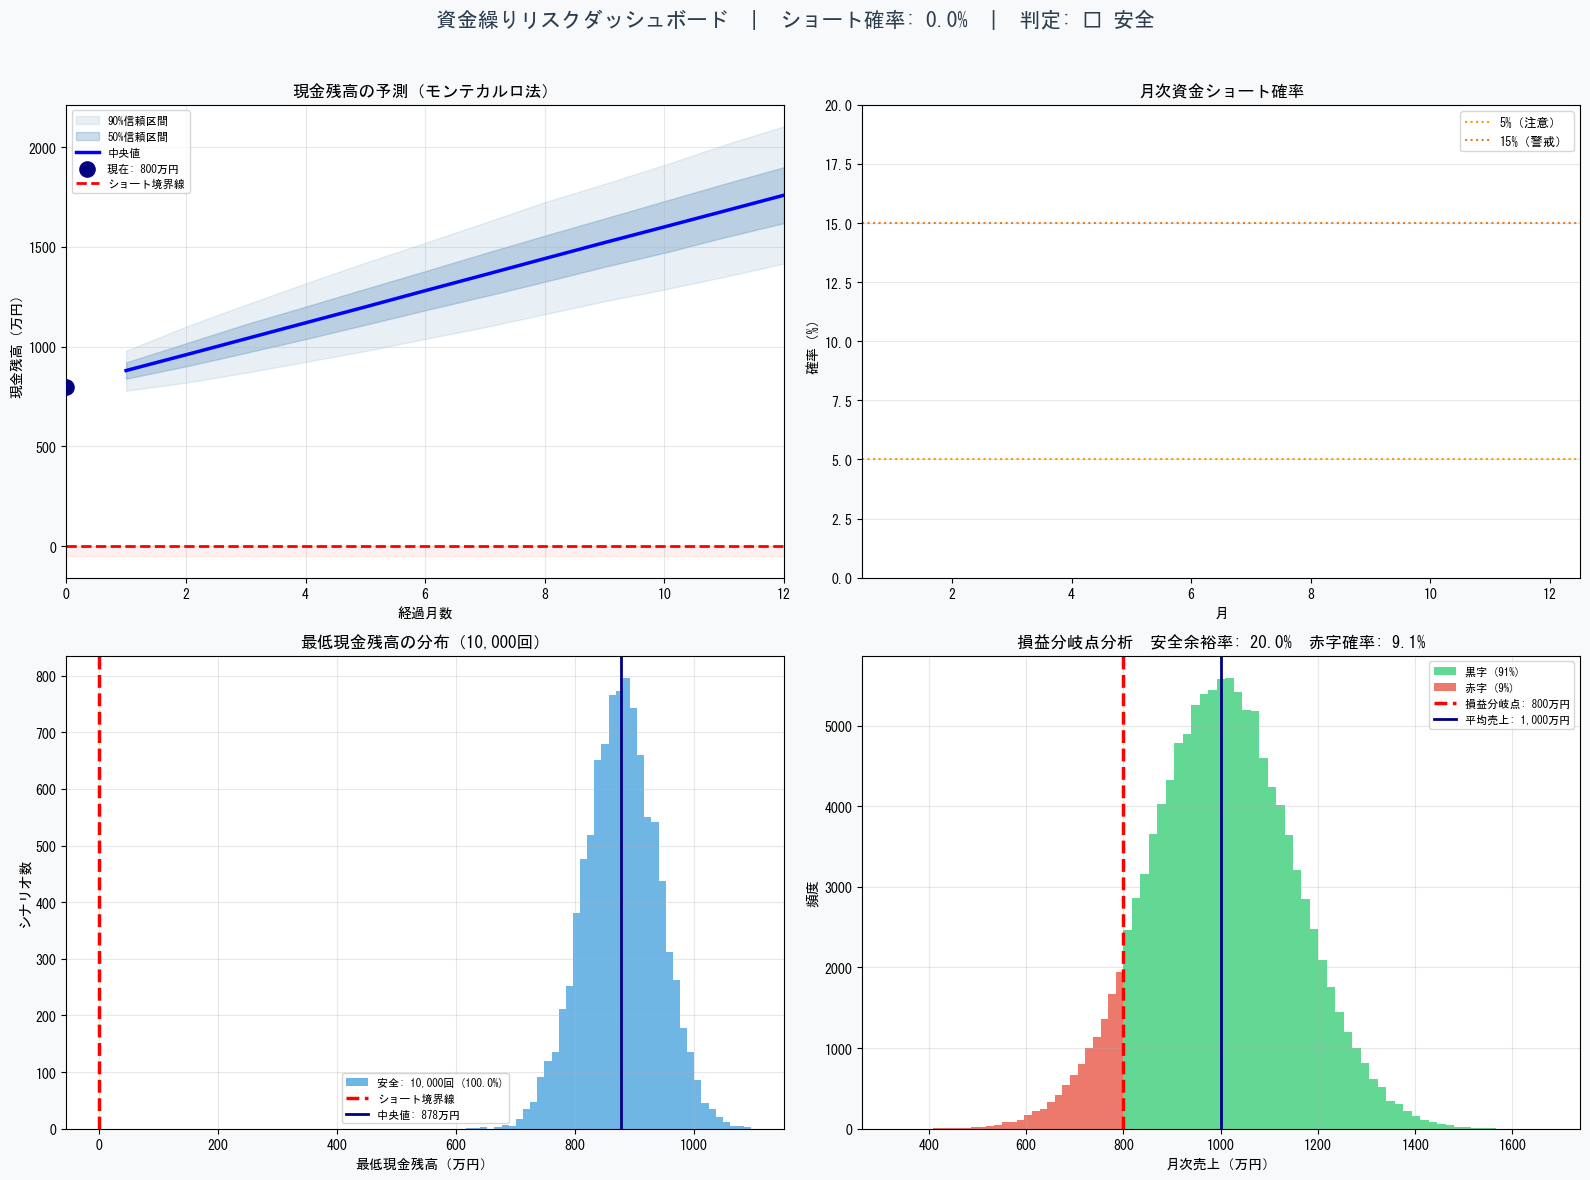

✅ ダッシュボード保存: 01_資金繰りダッシュボード.png


In [6]:
# ============================================================
# セル6: メインダッシュボード作成
# ============================================================
save_path = OUTPUT_DIR / '01_資金繰りダッシュボード.png'
create_main_dashboard(cash_paths, sales_sim, metrics, params, save_path)


In [7]:
# ============================================================
# セル7: 感度分析（What-if シミュレーション）
# ============================================================

# ── シナリオ定義 ──────────────────────────────────────────
# 変更したいシナリオを自由に追加・修正できます
sensitivity_scenarios = {
    '①ベースケース（現状）':       {},
    '②固定費10%削減':             {'monthly_fixed_cost': params.monthly_fixed_cost * 0.9},
    '③固定費20%削減':             {'monthly_fixed_cost': params.monthly_fixed_cost * 0.8},
    '④売上10%向上':               {'monthly_sales': params.monthly_sales * 1.1},
    '⑤売上10%減少':               {'monthly_sales': params.monthly_sales * 0.9},
    '⑥売上20%減少（ストレス）':   {'monthly_sales': params.monthly_sales * 0.8},
    '⑦変動リスク拡大（±30%）':   {'sales_volatility': 0.30},
    '⑧現金積増（+300万）':        {'cash_balance': params.cash_balance + 300},
}

np.random.seed(42)
sensitivity_results = run_sensitivity(params, sensitivity_scenarios)



───────────────────────────────────────────────────────
【感度分析: シナリオ別リスク比較】
───────────────────────────────────────────────────────
シナリオ                            ショート確率        最終残高（中央値）
───────────────────────────────────────────────────────
①ベースケース（現状）              🟢      0.0%          1,760 万円
②固定費10%削減                🟢      0.0%          2,144 万円
③固定費20%削減                🟢      0.0%          2,528 万円
④売上10%向上                 🟢      0.0%          2,240 万円
⑤売上10%減少                 🟢      0.0%          1,280 万円
⑥売上20%減少（ストレス）           🟢      0.0%            800 万円
⑦変動リスク拡大（±30%）           🟢      0.0%          1,759 万円
⑧現金積増（+300万）             🟢      0.0%          2,060 万円
───────────────────────────────────────────────────────


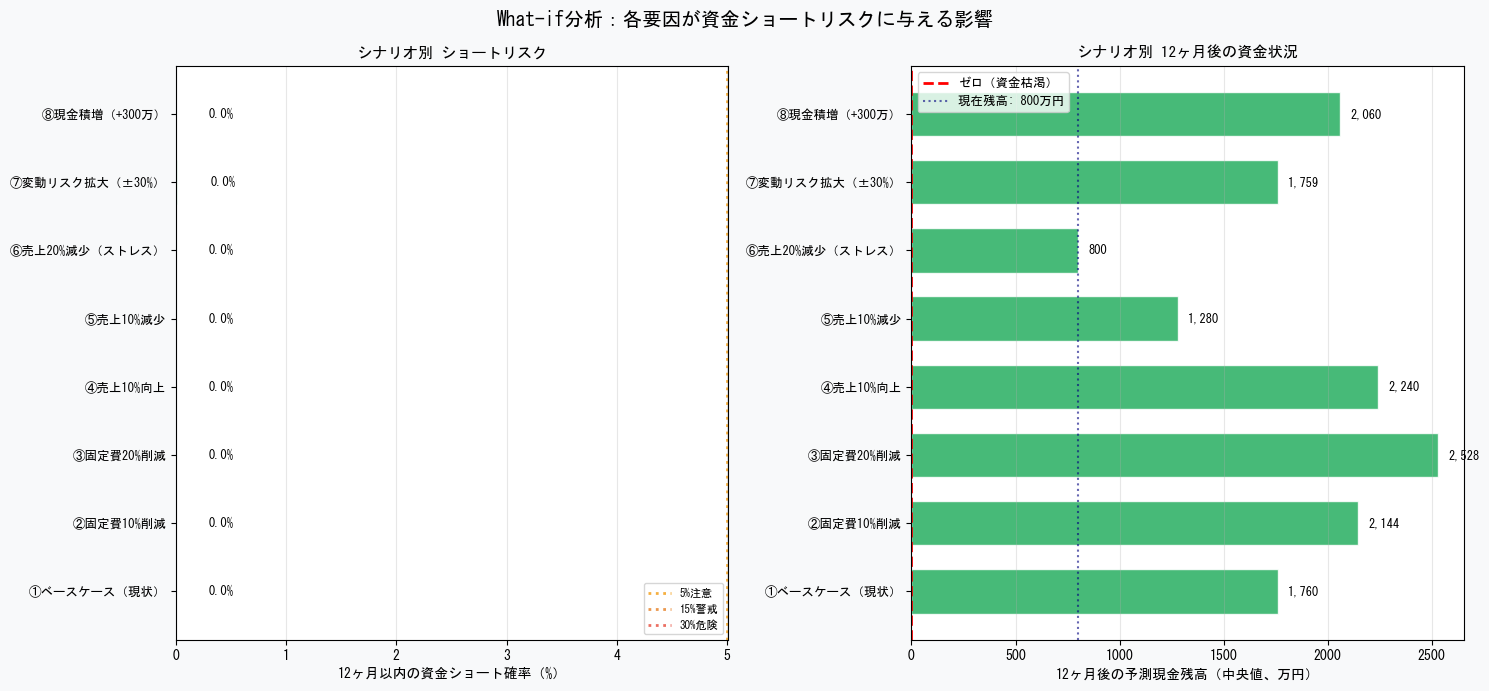

✅ 感度分析グラフ保存: 02_感度分析.png

✅ Phase 1 完了！
   作成ファイル: 01_資金繰りダッシュボード.png
              02_感度分析.png
   保存先: C:\Users\TSR\Desktop\CFMプログラム


In [8]:
# ============================================================
# セル8: 感度分析グラフ作成
# ============================================================
save_path = OUTPUT_DIR / '02_感度分析.png'
create_sensitivity_chart(sensitivity_results, params, save_path)

print()
print("=" * 55)
print("✅ Phase 1 完了！")
print(f"   作成ファイル: 01_資金繰りダッシュボード.png")
print(f"              02_感度分析.png")
print(f"   保存先: {OUTPUT_DIR}")
print("=" * 55)


## Phase 2: ストレステスト

In [9]:
# ============================================================
# セル9: 売上急落ストレステスト
# ============================================================
print("Phase 2-1: 売上急落ストレステスト")

np.random.seed(42)
stress_list = [
    ('①ベースケース（現状）',
     *run_monte_carlo(params)[:2]),
    ('②軽度の売上減少（-20%・3ヶ月目〜）',
     *run_stress(params, start_month=3, reduction_rate=0.20)[:2]),
    ('③中度の売上減少（-30%・3ヶ月目〜）',
     *run_stress(params, start_month=3, reduction_rate=0.30)[:2]),
    ('④重度の売上減少（-50%・即時）',
     *run_stress(params, start_month=1, reduction_rate=0.50)[:2]),
    ('⑤一時的ショック（-40%・3ヶ月間）',
     *run_stress(params, start_month=3, reduction_rate=0.40, duration=3)[:2]),
]

# 各シナリオのcash, salesを対応させてリスト化
stress_scenario_list = []
for i, item in enumerate(stress_list):
    name = item[0]; c = item[1]; s = item[2]
    stress_scenario_list.append((name, c, s))

stress_results = compare_scenarios(params, stress_scenario_list, '【売上急落ストレステスト結果】')


Phase 2-1: 売上急落ストレステスト

【売上急落ストレステスト結果】
  🟢 安全  ①ベースケース（現状）                            ショート: 0.0%  残高中央値: 1,760万円
  🟢 安全  ②軽度の売上減少（-20%・3ヶ月目〜）                   ショート: 0.0%  残高中央値: 962万円
  🟢 安全  ③中度の売上減少（-30%・3ヶ月目〜）                   ショート: 0.0%  残高中央値: 556万円
  🔴 危険  ④重度の売上減少（-50%・即時）                      ショート: 100.0%  残高中央値: -641万円
  🟢 安全  ⑤一時的ショック（-40%・3ヶ月間）                    ショート: 0.0%  残高中央値: 1,277万円


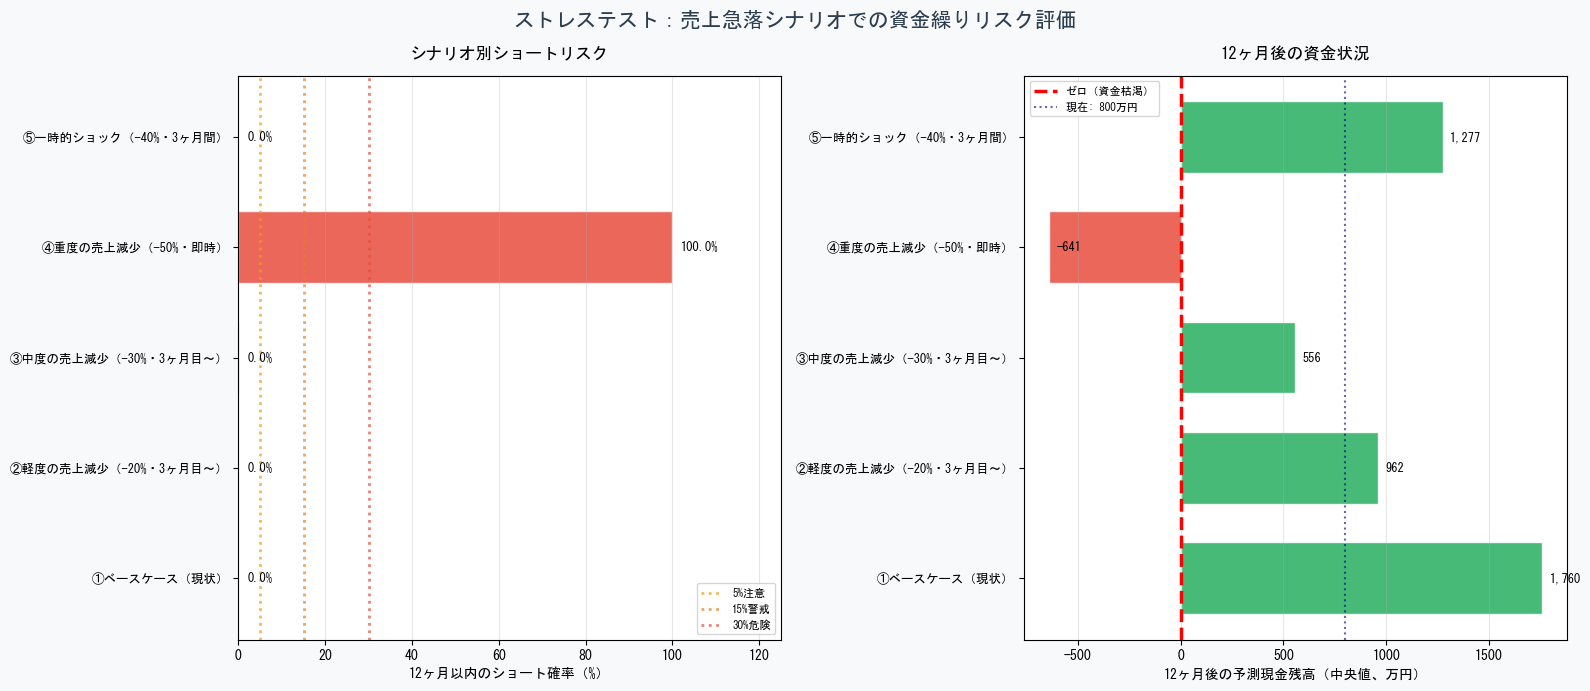

✅ グラフ保存: 03_売上急落ストレステスト.png


In [10]:
# ============================================================
# セル10: ストレステスト グラフ
# ============================================================
save_path = OUTPUT_DIR / '03_売上急落ストレステスト.png'
create_stress_chart(stress_results, params,
                    'ストレステスト：売上急落シナリオでの資金繰りリスク評価',
                    save_path)


In [11]:
# ============================================================
# セル11: 取引先倒産シミュレーション
# ============================================================
print("Phase 2-2: 取引先倒産シミュレーション")

np.random.seed(42)
base_cash, base_sales, _ = run_monte_carlo(params)

bankruptcy_list = [
    ('①ベースケース（倒産なし）', base_cash, base_sales),
]
for label, recv, share in [
    ('②小規模取引先倒産（売上10%・売掛100万）', 100, 0.10),
    ('③中規模取引先倒産（売上20%・売掛300万）', 300, 0.20),
    ('④大口取引先倒産（売上30%・売掛500万）',   500, 0.30),
    ('⑤最大手取引先倒産（売上40%・売掛800万）', 800, 0.40),
]:
    c = run_bankruptcy(params, month=6, receivable=recv, sales_share=share)
    # sales_simはbaseを使用（倒産後はsalesが減るが近似）
    bankruptcy_list.append((label, c, base_sales))

bankruptcy_results = compare_scenarios(params, bankruptcy_list, '【取引先倒産シミュレーション結果】')


Phase 2-2: 取引先倒産シミュレーション

【取引先倒産シミュレーション結果】
  🟢 安全  ①ベースケース（倒産なし）                          ショート: 0.0%  残高中央値: 1,760万円
  🟢 安全  ②小規模取引先倒産（売上10%・売掛100万）                ショート: 0.0%  残高中央値: 1,384万円
  🟢 安全  ③中規模取引先倒産（売上20%・売掛300万）                ショート: 0.0%  残高中央値: 896万円
  🟢 安全  ④大口取引先倒産（売上30%・売掛500万）                 ショート: 0.7%  残高中央値: 421万円
  🔴 危険  ⑤最大手取引先倒産（売上40%・売掛800万）                ショート: 83.4%  残高中央値: -163万円


In [12]:
# ============================================================
# セル12: 金利上昇 / 仕入高騰シミュレーション
# ============================================================
print("Phase 2-3&4: 金利上昇・仕入価格高騰")
print()

# ── 金利上昇 ─────────────────────────────────────────────
LOAN_BALANCE  = 3000   # ← 借入金残高（万円）を入力
CURRENT_RATE  = 0.01   # ← 現在の年利（例: 1.0% → 0.01）

np.random.seed(42)
interest_list = [('①現状（金利変化なし）', base_cash, base_sales)]
for new_rate, label in [
    (0.015, '②金利+0.5%（1.0%→1.5%）'),
    (0.020, '③金利+1.0%（1.0%→2.0%）'),
    (0.030, '④金利+2.0%（1.0%→3.0%）'),
]:
    c, extra = run_interest_rise(params, LOAN_BALANCE, CURRENT_RATE, new_rate, rise_month=1)
    print(f"  {label}  月次利息増加: {extra:.1f}万円")
    interest_list.append((label, c, base_sales))

interest_results = compare_scenarios(params, interest_list, '【金利上昇シミュレーション結果】')
print()

# ── 仕入価格高騰 ──────────────────────────────────────────
np.random.seed(42)
cost_list = [('①現状（高騰なし）', base_cash, base_sales)]
for inc, label in [
    (0.03, '②原価率+3pt'),
    (0.05, '③原価率+5pt'),
    (0.10, '④原価率+10pt'),
]:
    c, s = run_cost_inflation(params, cost_increase_rate=inc)
    cost_list.append((label, c, s))

cost_results = compare_scenarios(params, cost_list, '【仕入価格高騰シミュレーション結果】')


Phase 2-3&4: 金利上昇・仕入価格高騰

  ②金利+0.5%（1.0%→1.5%）  月次利息増加: 1.2万円
  ③金利+1.0%（1.0%→2.0%）  月次利息増加: 2.5万円
  ④金利+2.0%（1.0%→3.0%）  月次利息増加: 5.0万円

【金利上昇シミュレーション結果】
  🟢 安全  ①現状（金利変化なし）                            ショート: 0.0%  残高中央値: 1,760万円
  🟢 安全  ②金利+0.5%（1.0%→1.5%）                    ショート: 0.0%  残高中央値: 1,745万円
  🟢 安全  ③金利+1.0%（1.0%→2.0%）                    ショート: 0.0%  残高中央値: 1,733万円
  🟢 安全  ④金利+2.0%（1.0%→3.0%）                    ショート: 0.0%  残高中央値: 1,697万円


【仕入価格高騰シミュレーション結果】
  🟢 安全  ①現状（高騰なし）                              ショート: 0.0%  残高中央値: 1,760万円
  🟢 安全  ②原価率+3pt                               ショート: 0.0%  残高中央値: 1,400万円
  🟢 安全  ③原価率+5pt                               ショート: 0.0%  残高中央値: 1,163万円
  🟢 安全  ④原価率+10pt                              ショート: 0.0%  残高中央値: 557万円


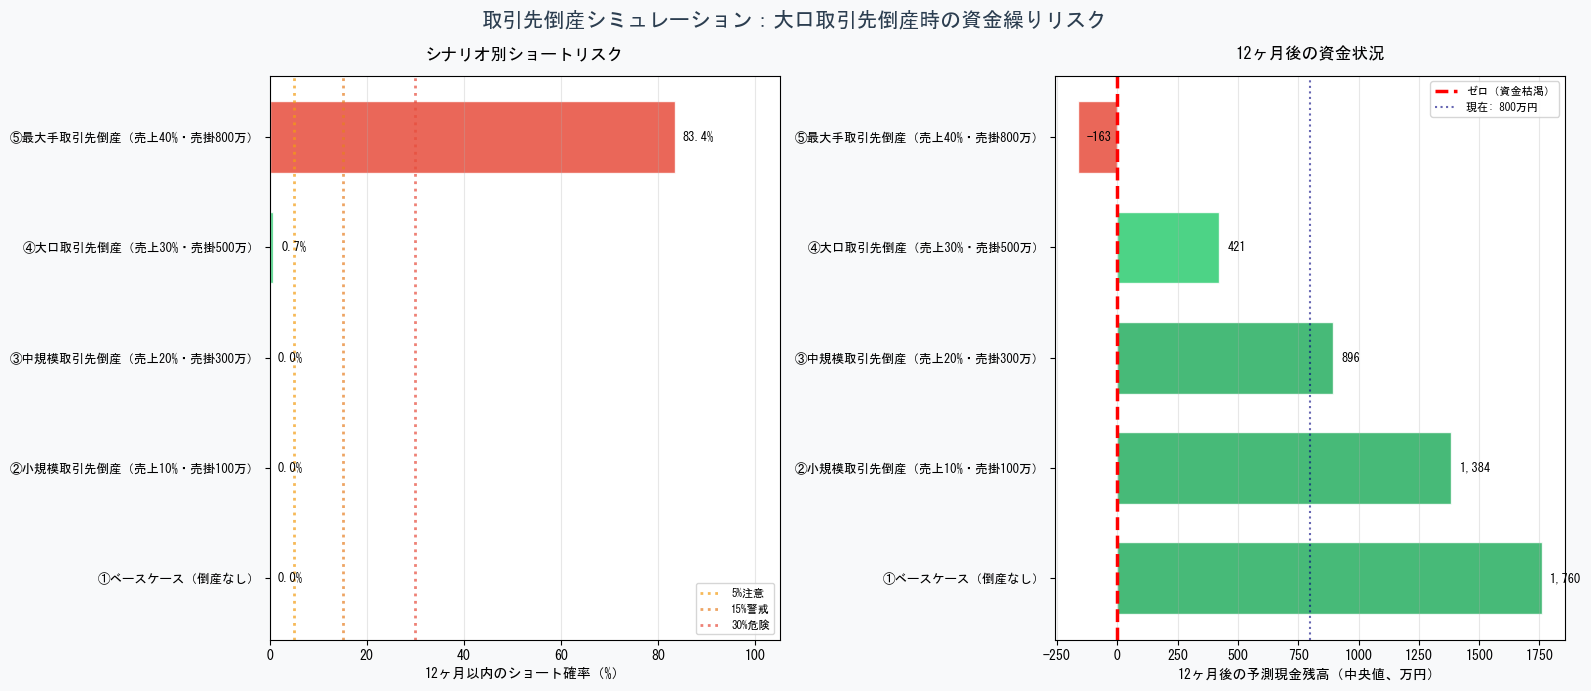

✅ グラフ保存: 04_取引先倒産リスク.png


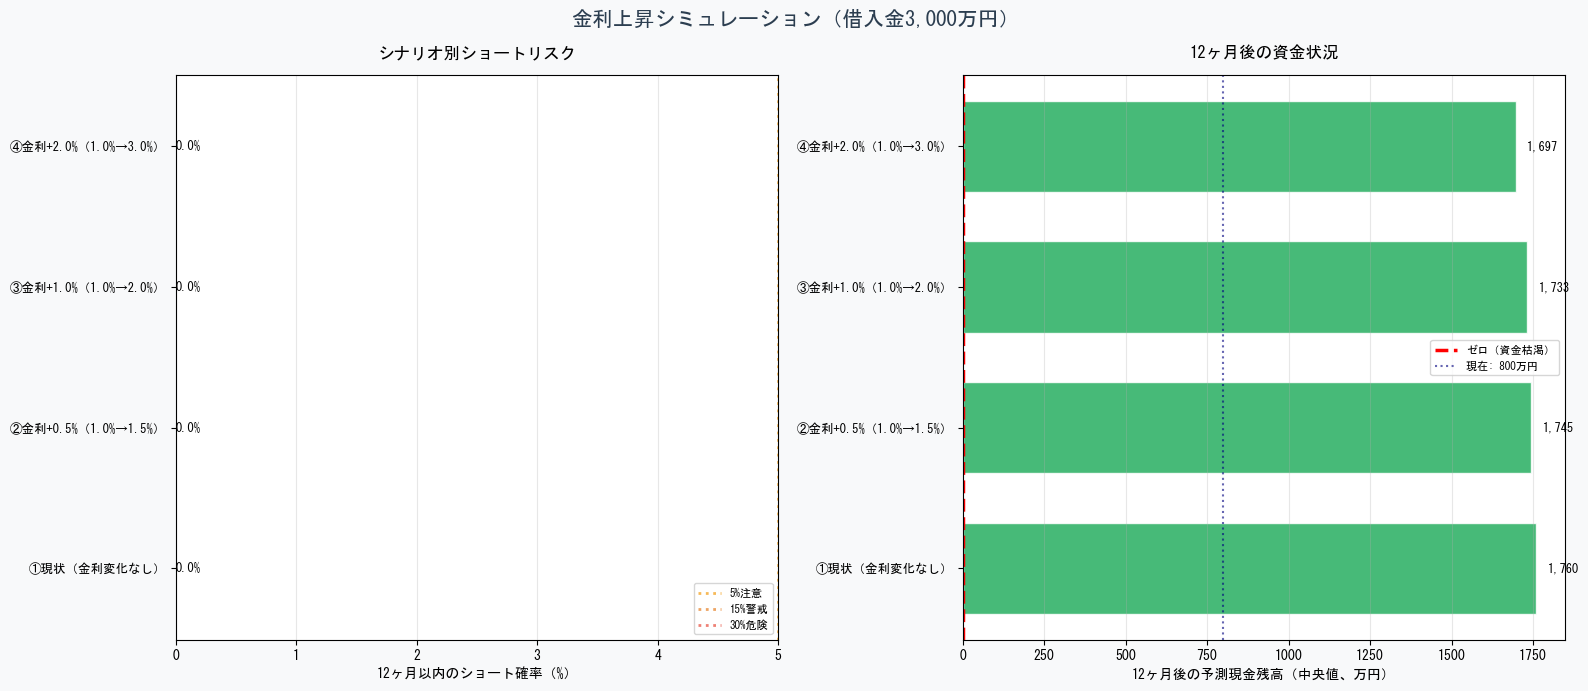

✅ グラフ保存: 05_金利上昇影響.png


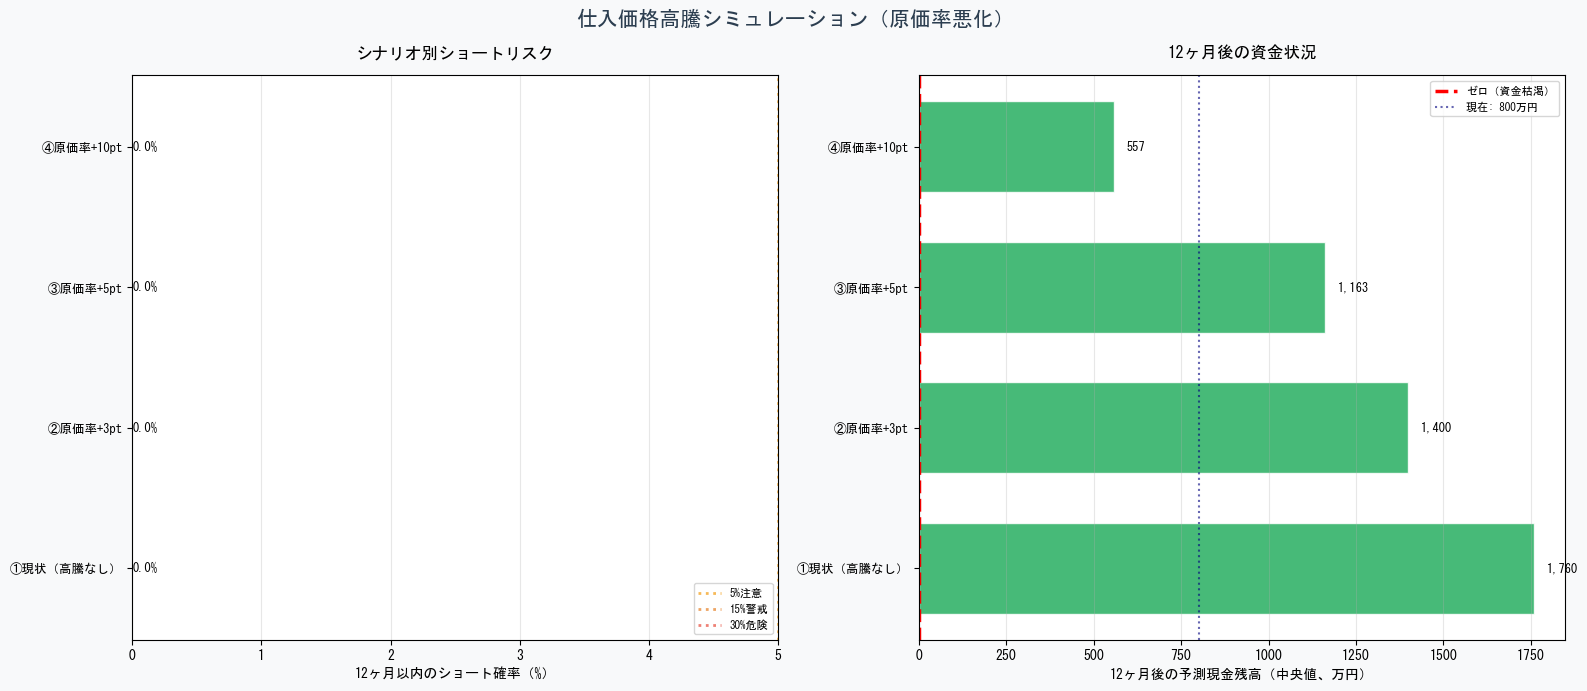

✅ グラフ保存: 06_仕入高騰影響.png

✅ Phase 2 完了！
   📊 03_売上急落ストレステスト.png
   📊 04_取引先倒産リスク.png
   📊 05_金利上昇影響.png
   📊 06_仕入高騰影響.png
   保存先: C:\Users\TSR\Desktop\CFMプログラム


In [13]:
# ============================================================
# セル13: Phase 2 グラフ一括作成
# ============================================================
np.random.seed(42)

create_stress_chart(bankruptcy_results, params,
                    '取引先倒産シミュレーション：大口取引先倒産時の資金繰りリスク',
                    OUTPUT_DIR / '04_取引先倒産リスク.png')

create_stress_chart(interest_results, params,
                    f'金利上昇シミュレーション（借入金{LOAN_BALANCE:,}万円）',
                    OUTPUT_DIR / '05_金利上昇影響.png')

create_stress_chart(cost_results, params,
                    '仕入価格高騰シミュレーション（原価率悪化）',
                    OUTPUT_DIR / '06_仕入高騰影響.png')

print()
print("=" * 55)
print("✅ Phase 2 完了！")
for f in ['03_売上急落ストレステスト.png','04_取引先倒産リスク.png',
          '05_金利上昇影響.png','06_仕入高騰影響.png']:
    print(f"   📊 {f}")
print(f"   保存先: {OUTPUT_DIR}")
print("=" * 55)


## Phase 3: 改善策提案エンジン

> 「では、どうすればいいか」を提案します。  
> 業種の商慣行に基づく現実的な難易度で評価します。


In [14]:
# ============================================================
# セル14: 業種診断・改善策の生成
# ============================================================
print("=" * 60)
print(f"Phase 3: 改善策提案エンジン  業種: {INDUSTRY}")
print("=" * 60)

# ── ベースライン確率の算出 ──
np.random.seed(42)
cp_base, ss_base, _ = run_monte_carlo(params)
base_shortage_prob = float(np.mean(cp_base[:, 1:].min(axis=1) < 0))
print(f"\n【ベースライン】ショート確率（{params.simulation_months}ヶ月以内）: {base_shortage_prob:.1%}")

# ── 業種診断 ──
priority_cats, diag_messages = diagnose(params, INDUSTRY)
print("\n【診断結果】")
for msg in diag_messages:
    print(f"  {msg}")

# ── 改善策リスト生成 ──
measures = build_measures(params, INDUSTRY)
print(f"\n改善策を {len(measures)} 件生成しました。シミュレーション実行中...")


Phase 3: 改善策提案エンジン  業種: IT・システム開発

【ベースライン】ショート確率（12ヶ月以内）: 0.0%

【診断結果】
  【注意】現金残高が固定費2.5ヶ月分。資金調達でバッファーを確保しながら他の対策を進めてください。
  【要注意】固定費比率80%。値上げ・仕入改善で粗利率改善の余地があります。
  【業種制約】売掛サイト30日は業種下限30日に近く、大幅短縮は困難です。
  【収益】月次純CF（平均）: +80万円（黒字基調）。変動率15%の下振れに注意。

改善策を 15 件生成しました。シミュレーション実行中...


In [15]:
# ============================================================
# セル15: 各改善策のシミュレーション実行
# ============================================================
np.random.seed(42)
improvement_results = run_improvement_analysis(params, measures, base_shortage_prob)

DIFF_ORD = {'低':0,'低〜中':1,'中':2,'中〜高':2.5,'高':3,'実質困難':9}
print(f"\n{'─'*75}")
print(f"【改善効果ランキング】（ベース確率: {base_shortage_prob:.1%}）")
print(f"{'─'*75}")
print(f"{'':2} {'改善策':38} {'難易度':9} {'効果':>9} {'実施後':>8}  月次コスト")
print(f"{'─'*75}")
for i, r in enumerate(improvement_results, 1):
    m   = r['measure']
    imp = r['improvement']
    flag   = '★ ' if m.category in priority_cats else '  '
    eff    = f"-{imp*100:.1f}pt" if imp > 0.005 else "  変化なし"
    cost   = f"{m.monthly_cost:.1f}万円/月" if m.monthly_cost else "—"
    print(f"{flag}{i:>2}. {m.name[:38]:38} {m.difficulty:9} {eff:>9} → {r['new_prob']:.1%}  {cost}")
print(f"{'─'*75}")
print("★ = 診断で優先推奨されたカテゴリ")



───────────────────────────────────────────────────────────────────────────
【改善効果ランキング】（ベース確率: 0.0%）
───────────────────────────────────────────────────────────────────────────
   改善策                                    難易度              効果      実施後  月次コスト
───────────────────────────────────────────────────────────────────────────
   1. 売掛サイト短縮（業種下限30日に近く実質困難）                実質困難           変化なし → 0.0%  —
   2. 固定費 3%削減（月△10万円）                       低              変化なし → 0.0%  —
   3. 固定費 5%削減（月△16万円）                       低〜中            変化なし → 0.0%  —
   4. 固定費 10%削減（月△32万円）                      中              変化なし → 0.0%  —
★  5. 粗利率 +1pt（値上げ/仕入交渉）                     低              変化なし → 0.0%  —
★  6. 粗利率 +2pt（値上げ/仕入交渉）                     中              変化なし → 0.0%  —
★  7. 粗利率 +3pt（値上げ/仕入交渉）                     高              変化なし → 0.0%  —
★  8. 当座貸越枠 320万円（固定費1ヶ月分）                   低〜中            変化なし → 0.0%  0.7万円/月
★  9. 当座貸越枠 640万円（固定費2ヶ月分）                   中              変化

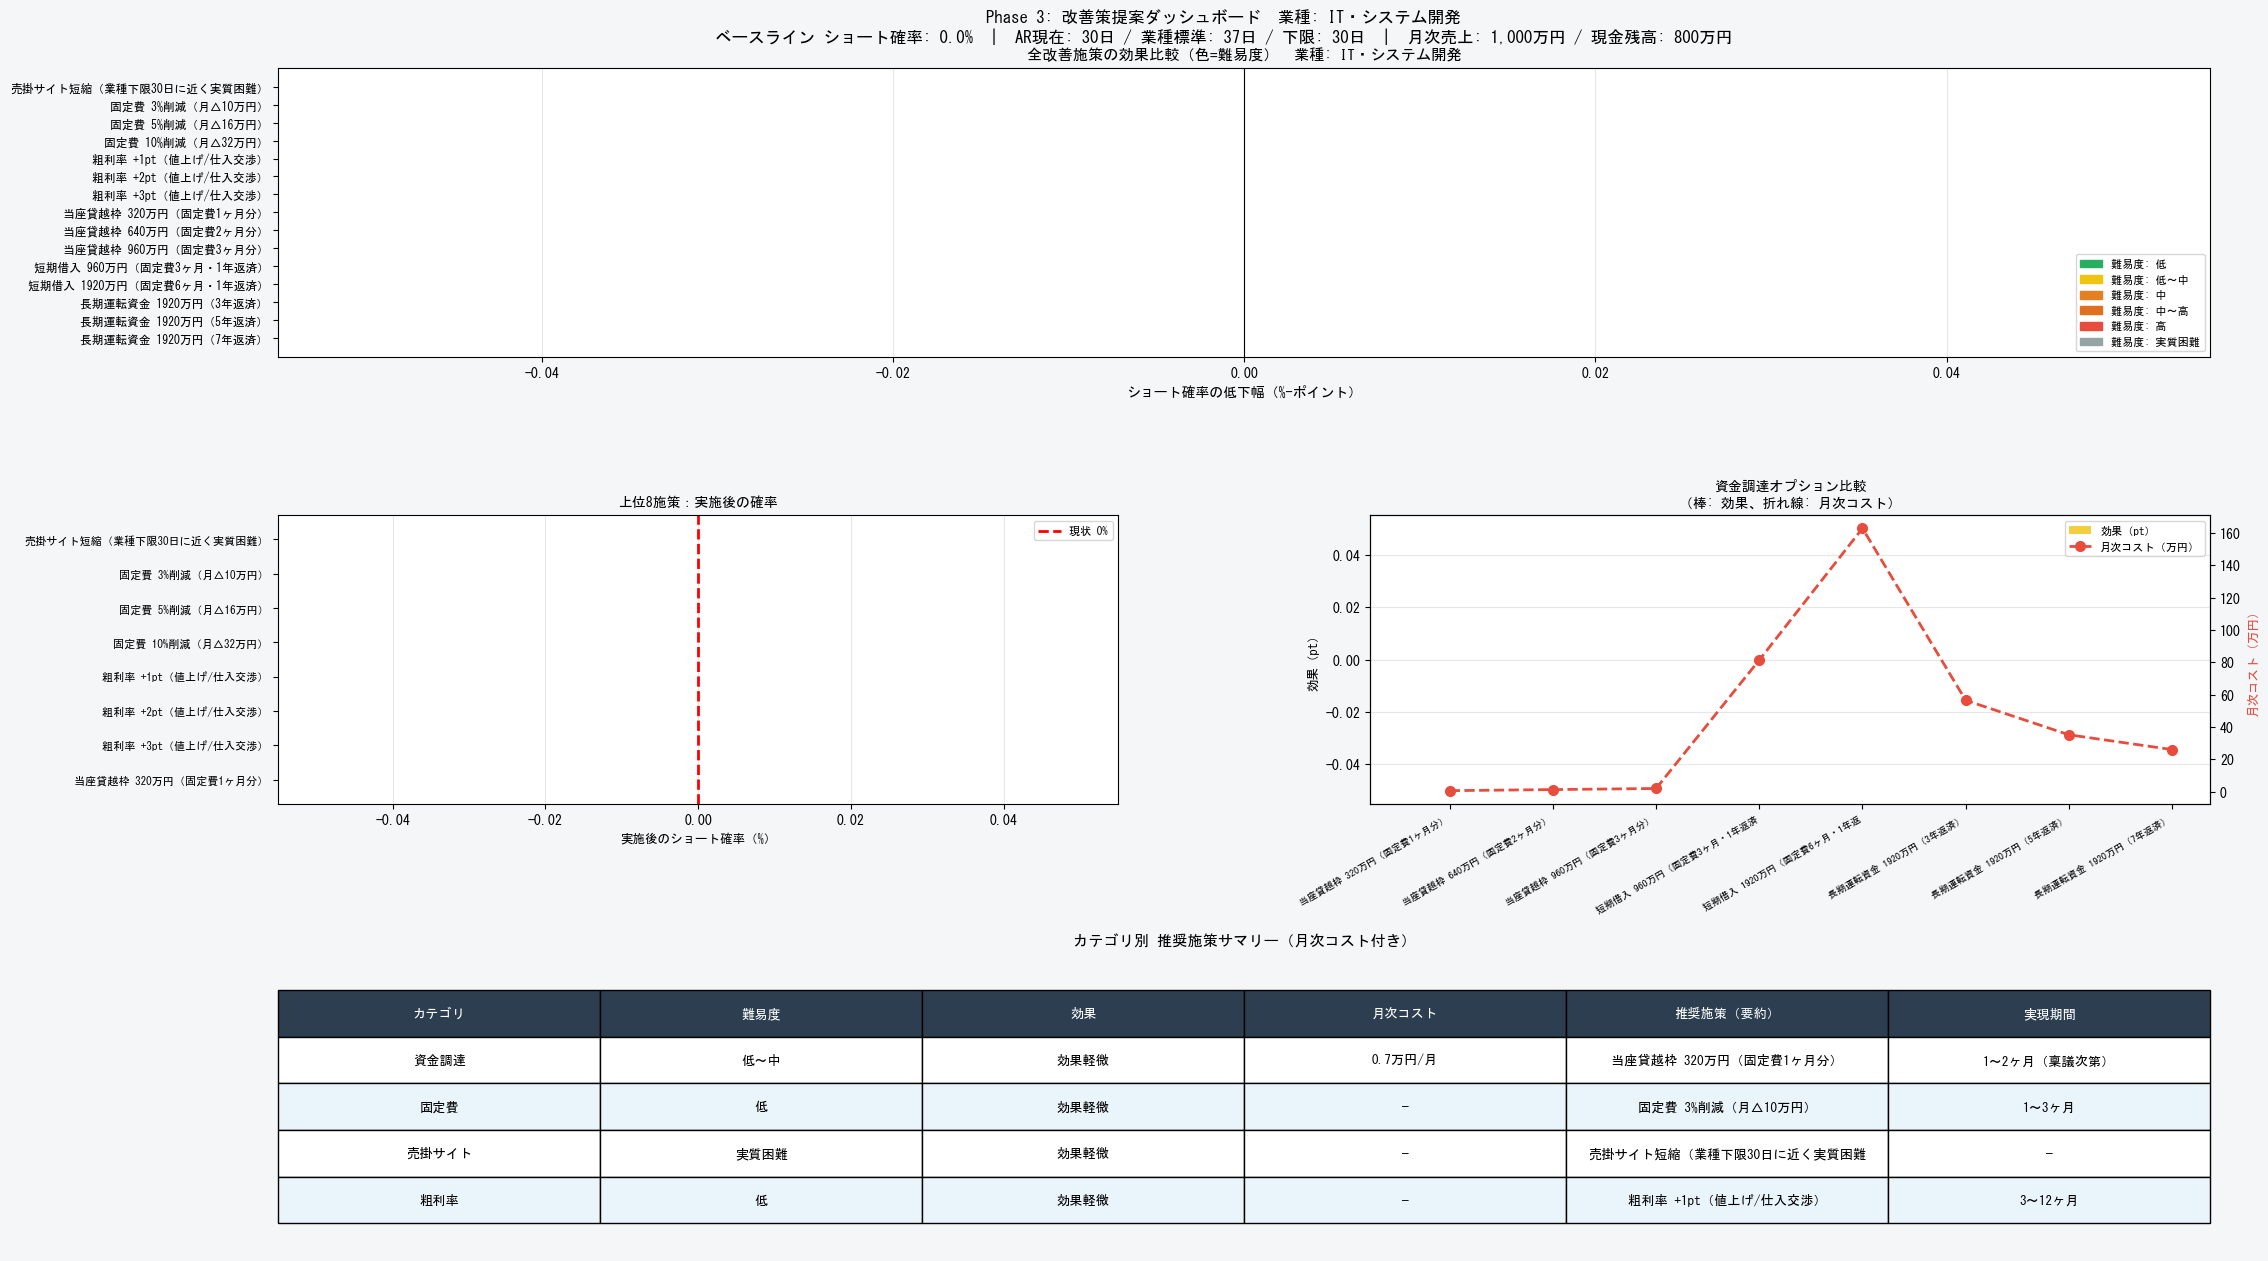

✅ グラフ保存: 07_改善策提案ダッシュボード.png


In [16]:
# ============================================================
# セル16: 改善策ダッシュボード作成
# ============================================================
save_path = OUTPUT_DIR / '07_改善策提案ダッシュボード.png'
create_improvement_dashboard(improvement_results, base_shortage_prob,
                             params, INDUSTRY, save_path)


In [17]:
# ============================================================
# セル17: 資金調達オプション詳細レポート
# ============================================================
fin_results = [r for r in improvement_results if r['measure'].category == 'financing']

print("=" * 70)
print("資金調達オプション 詳細比較")
print("=" * 70)
print(f"\n{'施策名':35} {'難易度':8} {'効果':>9} {'月次コスト':>12} {'期間'}")
print("─" * 70)
for r in fin_results:
    m   = r['measure']
    imp = r['improvement']
    eff = f"-{imp*100:.1f}pt" if imp > 0.005 else "  変化なし"
    print(f"{m.name[:35]:35} {m.difficulty:8} {eff:>9} {m.monthly_cost:>9.1f}万円/月  {m.timeline}")

print()
print("【資金調達の使い分けガイド】")
print("─" * 60)
print("■ 当座貸越枠の設定")
print("  → 緊急時の「保険」。枠を設定するだけでコストはほぼゼロ。")
print("  → 季節変動・大口入金遅れのバッファーとして最適。")
print("  → 「なんとかなってから頼む」では手遅れ。余裕があるうちに設定を。")
print()
print("■ 短期借入（1年以内）")
print("  → 一時的な資金不足（大型仕入れ・賞与直前）への対応。")
print("  → 月次返済が固定費に上乗せされるため、期間中のCFに要注意。")
print()
print("■ 長期運転資金（3〜7年）")
print("  → 慢性的な運転資本不足の「構造的解決」。")
print("  → 月次返済が軽く長期安定するが、審査・担保が必要な場合あり。")
print("  → 保証協会付融資を活用すると条件が緩和されやすい。")


資金調達オプション 詳細比較

施策名                                 難易度             効果        月次コスト 期間
──────────────────────────────────────────────────────────────────────
当座貸越枠 320万円（固定費1ヶ月分）                低〜中           変化なし       0.7万円/月  1〜2ヶ月（稟議次第）
当座貸越枠 640万円（固定費2ヶ月分）                中             変化なし       1.3万円/月  1〜2ヶ月（稟議次第）
当座貸越枠 960万円（固定費3ヶ月分）                中             変化なし       2.0万円/月  1〜2ヶ月（稟議次第）
短期借入 960万円（固定費3ヶ月・1年返済）             中             変化なし      81.4万円/月  1〜2ヶ月
短期借入 1920万円（固定費6ヶ月・1年返済）            中             変化なし     162.8万円/月  1〜2ヶ月
長期運転資金 1920万円（3年返済）                 中             変化なし      56.5万円/月  2〜3ヶ月（長期融資の審査期間を含む）
長期運転資金 1920万円（5年返済）                 中             変化なし      35.2万円/月  2〜3ヶ月（長期融資の審査期間を含む）
長期運転資金 1920万円（7年返済）                 中〜高           変化なし      26.1万円/月  2〜3ヶ月（長期融資の審査期間を含む）

【資金調達の使い分けガイド】
────────────────────────────────────────────────────────────
■ 当座貸越枠の設定
  → 緊急時の「保険」。枠を設定するだけでコストはほぼゼロ。
  → 季節変動・大口入金遅れのバッファーとして最適。
  → 「なんとかなってから頼む」では手遅れ。余裕が

In [18]:
# ============================================================
# セル18: ★★複数施策の組み合わせ試算★★
# ============================================================

# ── ★ここを編集してください★ ──────────────────────────────
# 実施したい施策を True にしてください

COMBO = {
    # 【資金調達】いずれか1つを選択
    '当座貸越枠（固定費1ヶ月分）':    True,   # まず設定すべき保険
    '短期借入（固定費3ヶ月・1年）':   False,  # 一時的な大きな不足向け
    '長期運転資金（固定費6ヶ月・5年）':False,  # 慢性的不足の構造解決

    # 【固定費削減】どちらか一方を選択
    '固定費3%削減':                   True,   # 通信費・サブスク等から着手
    '固定費5%削減':                   False,  # リース等も含めた見直し

    # 【売掛サイト短縮】業種下限を考慮して自動制限
    '売掛サイト短縮（小幅）':         False,  # 新規取引先から段階的に

    # 【粗利率改善】
    '粗利率+1pt':                     False,  # 一部商品の価格改定
}

# ── 組み合わせパラメータの構築 ────────────────────────────
def apply_combo(base_params, combo, industry):
    p = copy.copy(base_params)
    applied = []
    info    = get_industry_info(industry)

    if combo.get('当座貸越枠（固定費1ヶ月分）'):
        p.cash_balance += base_params.monthly_fixed_cost
        applied.append('当座貸越枠（固定費1ヶ月分）')

    if combo.get('短期借入（固定費3ヶ月・1年）'):
        amount = base_params.monthly_fixed_cost * 3
        repay  = amount / 12 + amount * 0.0175 / 12
        p.cash_balance       += amount
        p.monthly_fixed_cost += repay
        applied.append(f'短期借入 {amount:.0f}万円（月返済 {repay:.1f}万円）')

    if combo.get('長期運転資金（固定費6ヶ月・5年）'):
        amount = base_params.monthly_fixed_cost * 6
        repay  = amount / 60 + amount * 0.020 / 12
        p.cash_balance       += amount
        p.monthly_fixed_cost += repay
        applied.append(f'長期運転資金 {amount:.0f}万円（月返済 {repay:.1f}万円）')

    # 固定費削減は大きい方を適用
    if combo.get('固定費5%削減'):
        p.monthly_fixed_cost = base_params.monthly_fixed_cost * 0.95
        applied.append('固定費5%削減')
    elif combo.get('固定費3%削減'):
        p.monthly_fixed_cost = base_params.monthly_fixed_cost * 0.97
        applied.append('固定費3%削減')

    # 売掛サイト短縮（業種下限を超えない範囲で5日まで）
    if combo.get('売掛サイト短縮（小幅）'):
        max_cut = max(0, base_params.accounts_receivable_days - info['floor'])
        cut     = min(5, max_cut)
        if cut > 0:
            p.accounts_receivable_days -= cut
            p.cash_balance += (base_params.monthly_sales / 30) * cut
            applied.append(f'売掛サイト{cut}日短縮')
        else:
            applied.append('売掛サイト短縮: 業種下限のため適用不可')

    if combo.get('粗利率+1pt'):
        p.cost_rate = max(p.cost_rate - 0.01, 0)
        applied.append('粗利率+1pt（値上げ/仕入交渉）')

    return p, applied


# ── 実行 ─────────────────────────────────────────────────
combo_params, applied_list = apply_combo(params, COMBO, INDUSTRY)
np.random.seed(42)
cp_combo, _, _ = run_monte_carlo(combo_params)
combo_prob = float(np.mean(cp_combo[:, 1:].min(axis=1) < 0))

print("=" * 60)
print("複数施策の組み合わせ効果試算")
print("=" * 60)
print(f"\n実施した施策:")
for a in applied_list:
    print(f"  ✔ {a}")
if not applied_list:
    print("  （すべてOff — 上のCOMBOでTrueにしてください）")

print(f"\n現状のショート確率   : {base_shortage_prob:.1%}")
print(f"組み合わせ実施後の確率: {combo_prob:.1%}")
print(f"合計削減効果         : -{(base_shortage_prob - combo_prob)*100:.1f}pt")

if combo_prob <= 0.10:
    print("\n✅ 安全水準（10%以下）を達成しています。")
elif combo_prob <= 0.30:
    print("\n⚠️ 注意水準（30%以下）。追加施策や継続モニタリングが必要です。")
else:
    print("\n🚨 危険水準（30%超）。より強力な組み合わせを検討してください。")

print()
print("=" * 60)
print("✅ Phase 3 完了！")
print()
print("【作成されたファイル一覧】")
for f in ['01_資金繰りダッシュボード.png','02_感度分析.png',
          '03_売上急落ストレステスト.png','04_取引先倒産リスク.png',
          '05_金利上昇影響.png','06_仕入高騰影響.png',
          '07_改善策提案ダッシュボード.png']:
    print(f"  📊 {f}")
print(f"\n  保存先: {OUTPUT_DIR}")
print("=" * 60)


複数施策の組み合わせ効果試算

実施した施策:
  ✔ 当座貸越枠（固定費1ヶ月分）
  ✔ 固定費3%削減

現状のショート確率   : 0.0%
組み合わせ実施後の確率: 0.0%
合計削減効果         : -0.0pt

✅ 安全水準（10%以下）を達成しています。

✅ Phase 3 完了！

【作成されたファイル一覧】
  📊 01_資金繰りダッシュボード.png
  📊 02_感度分析.png
  📊 03_売上急落ストレステスト.png
  📊 04_取引先倒産リスク.png
  📊 05_金利上昇影響.png
  📊 06_仕入高騰影響.png
  📊 07_改善策提案ダッシュボード.png

  保存先: C:\Users\TSR\Desktop\CFMプログラム


## Phase 4: Excel出力

> シミュレーション結果を5シート構成のExcelファイルに出力します。  
> **Phase 1〜3を実行済みの状態**でこのセルを実行してください。


In [19]:
# ============================================================
# Phase 4 セル19: Excel出力関数の定義（変更不要）
# ============================================================

from openpyxl import Workbook
from openpyxl.styles import (Font, PatternFill, Alignment,
                              Border, Side, numbers as xl_numbers)
from openpyxl.utils import get_column_letter
from openpyxl.chart import BarChart, LineChart, Reference
from openpyxl.chart.series import DataPoint
import numpy as np

# ── スタイル定数 ──────────────────────────────────────────
FONT_NAME  = 'メイリオ'

# 色定義
C_HEADER_BG  = '2C3E50'  # ヘッダー背景（濃紺）
C_HEADER_FG  = 'FFFFFF'  # ヘッダー文字（白）
C_SUB_BG     = 'D6EAF8'  # サブヘッダー背景（薄青）
C_INPUT_FG   = '0000FF'  # 入力値（青）
C_SAFE       = '27AE60'  # 安全（緑）
C_CAUTION    = 'F39C12'  # 注意（黄）
C_WARNING    = 'E67E22'  # 警戒（橙）
C_DANGER     = 'E74C3C'  # 危険（赤）
C_GRAY       = 'F2F3F4'  # 交互行背景
C_BORDER     = 'BDC3C7'  # 罫線

def thin_border():
    s = Side(style='thin', color=C_BORDER)
    return Border(left=s, right=s, top=s, bottom=s)

def header_style(ws, row, col, value, width=None):
    c = ws.cell(row=row, column=col, value=value)
    c.font      = Font(name=FONT_NAME, bold=True, color=C_HEADER_FG, size=10)
    c.fill      = PatternFill('solid', start_color=C_HEADER_BG)
    c.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
    c.border    = thin_border()
    if width:
        ws.column_dimensions[get_column_letter(col)].width = width
    return c

def sub_header_style(ws, row, col, value):
    c = ws.cell(row=row, column=col, value=value)
    c.font      = Font(name=FONT_NAME, bold=True, size=10)
    c.fill      = PatternFill('solid', start_color=C_SUB_BG)
    c.alignment = Alignment(horizontal='left', vertical='center')
    c.border    = thin_border()
    return c

def data_cell(ws, row, col, value, fmt=None, bold=False,
              fg=None, bg=None, align='right'):
    c = ws.cell(row=row, column=col, value=value)
    c.font      = Font(name=FONT_NAME, bold=bold,
                       color=fg if fg else '000000', size=10)
    c.alignment = Alignment(horizontal=align, vertical='center')
    c.border    = thin_border()
    if fmt:
        c.number_format = fmt
    if bg:
        c.fill = PatternFill('solid', start_color=bg)
    return c

def risk_color(prob):
    if prob < 0.05: return C_SAFE
    if prob < 0.15: return C_CAUTION
    if prob < 0.30: return C_WARNING
    return C_DANGER

def risk_label(prob):
    if prob < 0.05: return '安全'
    if prob < 0.15: return '注意'
    if prob < 0.30: return '警戒'
    return '危険'

def set_col_widths(ws, widths: dict):
    for col, w in widths.items():
        ws.column_dimensions[col].width = w

def freeze_and_height(ws, freeze='A2', row_height=20):
    ws.freeze_panes = freeze
    for row in ws.iter_rows():
        ws.row_dimensions[row[0].row].height = row_height

print("✅ Excel出力関数（スタイル）定義完了")


✅ Excel出力関数（スタイル）定義完了


In [20]:
# ============================================================
# Phase 4 セル20: 各シート生成関数の定義（変更不要）
# ============================================================

def make_sheet1_params(wb, params, industry):
    """シート1: 入力パラメータ"""
    ws = wb.create_sheet('①入力パラメータ')
    ws.sheet_view.showGridLines = False

    # タイトル
    ws.merge_cells('A1:D1')
    t = ws['A1']
    t.value = '入力パラメータ一覧'
    t.font  = Font(name=FONT_NAME, bold=True, size=14)
    t.alignment = Alignment(horizontal='center', vertical='center')
    t.fill = PatternFill('solid', start_color=C_HEADER_BG)
    t.font = Font(name=FONT_NAME, bold=True, size=14, color=C_HEADER_FG)
    ws.row_dimensions[1].height = 30

    # 業種
    ws.merge_cells('A2:D2')
    ind = ws['A2']
    ind.value = f'業種: {industry}'
    ind.font  = Font(name=FONT_NAME, bold=True, size=11)
    ind.fill  = PatternFill('solid', start_color=C_SUB_BG)
    ind.alignment = Alignment(horizontal='left', vertical='center', indent=1)
    ws.row_dimensions[2].height = 22

    # ヘッダー行
    for col, (val, w) in enumerate([('項目',30),('入力値',15),('単位',10),('備考',30)], 1):
        header_style(ws, 3, col, val, w)
    ws.row_dimensions[3].height = 22

    rows = [
        ('月次平均売上',      params.monthly_sales,            '万円',  '過去3〜6ヶ月の平均'),
        ('現金・預金残高',    params.cash_balance,             '万円',  '今日時点の通帳残高'),
        ('月次固定費',        params.monthly_fixed_cost,       '万円',  '家賃・人件費・リース等'),
        ('売上原価率',        params.cost_rate,                '',      '例: 60%なら0.60'),
        ('売上変動率',        params.sales_volatility,         '',      '不明なら0.15'),
        ('売掛サイト',        params.accounts_receivable_days, '日',    '売上が現金になるまで'),
        ('シミュレーション期間', params.simulation_months,     'ヶ月',  ''),
        ('シミュレーション回数', params.num_simulations,       '回',    '多いほど精度UP'),
    ]

    # 自動計算値
    calc_rows = [
        ('粗利率',            params.gross_profit_rate(),      '',      '1 − 原価率'),
        ('月次平均粗利',      params.monthly_gross_profit(),   '万円',  '売上 × 粗利率'),
        ('月次純CF（平均）',  params.monthly_net_cf(),         '万円',  '粗利 − 固定費'),
        ('損益分岐点',        params.breakeven_sales(),        '万円/月', '固定費 ÷ 粗利率'),
        ('現金の安全余裕',    params.safety_months(),          'ヶ月分', '現金 ÷ 固定費'),
    ]

    for i, (name, val, unit, note) in enumerate(rows, 4):
        bg = C_GRAY if i % 2 == 0 else 'FFFFFF'
        data_cell(ws, i, 1, name,  align='left',  bg=bg)
        fmt = '0.0%' if unit == '' and val <= 1 else '#,##0' if unit in ['万円','回','日','ヶ月'] else '#,##0.0'
        data_cell(ws, i, 2, val,   fmt=fmt,       bg=bg, fg=C_INPUT_FG, bold=True)
        data_cell(ws, i, 3, unit,  align='center', bg=bg)
        data_cell(ws, i, 4, note,  align='left',  bg=bg)
        ws.row_dimensions[i].height = 20

    # 区切り
    sep_row = len(rows) + 4
    ws.merge_cells(f'A{sep_row}:D{sep_row}')
    sub_header_style(ws, sep_row, 1, '■ 自動計算値')

    for i, (name, val, unit, note) in enumerate(calc_rows, sep_row + 1):
        bg = C_GRAY if i % 2 == 0 else 'FFFFFF'
        data_cell(ws, i, 1, name,  align='left',  bg=bg)
        fmt = '0.0%' if unit == '' and val <= 1 else '#,##0.0' if 'ヶ月' in unit else '#,##0'
        data_cell(ws, i, 2, val,   fmt=fmt,       bg=bg)
        data_cell(ws, i, 3, unit,  align='center', bg=bg)
        data_cell(ws, i, 4, note,  align='left',  bg=bg)
        ws.row_dimensions[i].height = 20

    ws.freeze_panes = 'A4'


def make_sheet2_risk(wb, metrics, params):
    """シート2: リスク診断結果"""
    ws = wb.create_sheet('②リスク診断結果')
    ws.sheet_view.showGridLines = False
    set_col_widths(ws, {'A':28,'B':16,'C':12,'D':28})

    ws.merge_cells('A1:D1')
    t = ws['A1']
    t.value = 'リスク診断結果'
    t.font  = Font(name=FONT_NAME, bold=True, size=14, color=C_HEADER_FG)
    t.fill  = PatternFill('solid', start_color=C_HEADER_BG)
    t.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[1].height = 30

    prob  = metrics['shortage_prob']
    label = risk_label(prob)
    color = risk_color(prob)

    # 総合判定ボックス
    ws.merge_cells('A2:D2')
    r = ws['A2']
    r.value = f'総合判定: {label}  |  {params.simulation_months}ヶ月以内の資金ショート確率: {prob:.1%}'
    r.font  = Font(name=FONT_NAME, bold=True, size=13, color='FFFFFF')
    r.fill  = PatternFill('solid', start_color=color)
    r.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[2].height = 28

    # ヘッダー
    for col, val in enumerate(['指標','値','単位','コメント'], 1):
        header_style(ws, 3, col, val)
    ws.row_dimensions[3].height = 22

    bep    = metrics['bep']
    margin = (params.monthly_sales - bep) / params.monthly_sales

    result_rows = [
        ('資金ショート確率',         prob,                        '',       f'判定: {label}'),
        ('12ヶ月後残高（中央値）',   metrics['final_median'],     '万円',   ''),
        ('損益分岐点（月次）',       bep,                         '万円/月', ''),
        ('安全余裕率',               margin,                      '',       'プラスなら黒字基調'),
        ('赤字確率（平均）',         metrics['deficit_prob'],     '',       ''),
        ('現金の安全余裕',           params.safety_months(),      'ヶ月分', '3ヶ月以上が目安'),
    ]

    for i, (name, val, unit, comment) in enumerate(result_rows, 4):
        bg = C_GRAY if i % 2 == 0 else 'FFFFFF'
        data_cell(ws, i, 1, name,    align='left', bg=bg)
        fmt = '0.0%' if unit == '' else '#,##0'
        vc  = data_cell(ws, i, 2, val, fmt=fmt, bg=bg, bold=True)
        if name == '資金ショート確率':
            vc.fill = PatternFill('solid', start_color=color)
            vc.font = Font(name=FONT_NAME, bold=True, color='FFFFFF', size=10)
        data_cell(ws, i, 3, unit,    align='center', bg=bg)
        data_cell(ws, i, 4, comment, align='left',  bg=bg)
        ws.row_dimensions[i].height = 20

    # 月次ショート確率テーブル
    sep = len(result_rows) + 5
    ws.merge_cells(f'A{sep}:D{sep}')
    sub_header_style(ws, sep, 1, '■ 月次資金ショート確率の推移')
    ws.row_dimensions[sep].height = 22

    for col, val in enumerate(['月','ショート確率','判定',''], 1):
        header_style(ws, sep+1, col, val)

    mp = metrics['monthly_shortage']
    for i, p in enumerate(mp, 1):
        row = sep + 1 + i
        bg = C_GRAY if i % 2 == 0 else 'FFFFFF'
        data_cell(ws, row, 1, f'{i}ヶ月目', align='center', bg=bg)
        pc = data_cell(ws, row, 2, p, fmt='0.0%', bg=bg, bold=True)
        data_cell(ws, row, 3, risk_label(p), align='center',
                  bg=risk_color(p), fg='FFFFFF' if p >= 0.05 else '000000')
        data_cell(ws, row, 4, '', bg=bg)
        ws.row_dimensions[row].height = 18

    ws.freeze_panes = 'A4'


def make_sheet3_sensitivity(wb, sensitivity_results, params):
    """シート3: 感度分析"""
    ws = wb.create_sheet('③感度分析')
    ws.sheet_view.showGridLines = False
    set_col_widths(ws, {'A':32,'B':16,'C':18,'D':14})

    ws.merge_cells('A1:D1')
    t = ws['A1']
    t.value = 'What-if 感度分析'
    t.font  = Font(name=FONT_NAME, bold=True, size=14, color=C_HEADER_FG)
    t.fill  = PatternFill('solid', start_color=C_HEADER_BG)
    t.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[1].height = 30

    for col, (val, w) in enumerate(
        [('シナリオ',32),('ショート確率',16),('12ヶ月後残高（中央値）',22),('判定',12)], 1):
        header_style(ws, 2, col, val, w)
    ws.row_dimensions[2].height = 22

    for i, (name, prob, final) in enumerate(sensitivity_results, 3):
        bg = C_GRAY if i % 2 == 1 else 'FFFFFF'
        data_cell(ws, i, 1, name,  align='left', bg=bg)
        pc = data_cell(ws, i, 2, prob,  fmt='0.0%', bg=bg, bold=True)
        data_cell(ws, i, 3, final, fmt='#,##0',   bg=bg)
        jc = data_cell(ws, i, 4, risk_label(prob), align='center',
                       bg=risk_color(prob),
                       fg='FFFFFF' if prob >= 0.05 else '000000', bold=True)
        ws.row_dimensions[i].height = 20

    ws.freeze_panes = 'A3'


def make_sheet4_stress(wb, stress_results, bankruptcy_results,
                       interest_results, cost_results):
    """シート4: ストレステスト結果"""
    ws = wb.create_sheet('④ストレステスト')
    ws.sheet_view.showGridLines = False
    set_col_widths(ws, {'A':38,'B':16,'C':20,'D':14})

    ws.merge_cells('A1:D1')
    t = ws['A1']
    t.value = 'ストレステスト結果'
    t.font  = Font(name=FONT_NAME, bold=True, size=14, color=C_HEADER_FG)
    t.fill  = PatternFill('solid', start_color=C_HEADER_BG)
    t.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[1].height = 30

    def write_block(ws, start_row, title, results):
        ws.merge_cells(f'A{start_row}:D{start_row}')
        sub_header_style(ws, start_row, 1, f'■ {title}')
        ws.row_dimensions[start_row].height = 22

        for col, val in enumerate(['シナリオ','ショート確率','12ヶ月後残高（中央値）','判定'], 1):
            header_style(ws, start_row+1, col, val)
        ws.row_dimensions[start_row+1].height = 22

        for i, (name, prob, final) in enumerate(results, start_row+2):
            bg = C_GRAY if i % 2 == 0 else 'FFFFFF'
            data_cell(ws, i, 1, name,  align='left', bg=bg)
            data_cell(ws, i, 2, prob,  fmt='0.0%',   bg=bg, bold=True)
            data_cell(ws, i, 3, final, fmt='#,##0',  bg=bg)
            data_cell(ws, i, 4, risk_label(prob), align='center',
                      bg=risk_color(prob),
                      fg='FFFFFF' if prob >= 0.05 else '000000', bold=True)
            ws.row_dimensions[i].height = 20

        return start_row + len(results) + 3

    next_row = write_block(ws, 2,  '売上急落シナリオ',         stress_results)
    next_row = write_block(ws, next_row, '取引先倒産シナリオ', bankruptcy_results)
    next_row = write_block(ws, next_row, '金利上昇シナリオ',   interest_results)
    next_row = write_block(ws, next_row, '仕入価格高騰シナリオ', cost_results)

    ws.freeze_panes = 'A2'


def make_sheet5_improvement(wb, improvement_results, base_prob, industry):
    """シート5: 改善策提案"""
    ws = wb.create_sheet('⑤改善策提案')
    ws.sheet_view.showGridLines = False
    set_col_widths(ws, {'A':38,'B':12,'C':12,'D':14,'E':14,'F':20,'G':16})

    ws.merge_cells('A1:G1')
    t = ws['A1']
    t.value = f'改善策提案  業種: {industry}  ベースライン ショート確率: {base_prob:.1%}'
    t.font  = Font(name=FONT_NAME, bold=True, size=13, color=C_HEADER_FG)
    t.fill  = PatternFill('solid', start_color=C_HEADER_BG)
    t.alignment = Alignment(horizontal='center', vertical='center')
    ws.row_dimensions[1].height = 30

    DIFF_COLOR = {
        '低':'C8E6C9','低〜中':'FFF9C4','中':'FFE0B2',
        '中〜高':'FFCCBC','高':'FFCDD2','実質困難':'ECEFF1'}
    CAT_JP = {
        'receivable':'売掛サイト','fixedcost':'固定費',
        'margin':'粗利率','financing':'資金調達'}

    for col, (val, w) in enumerate([
        ('改善策',38),('カテゴリ',12),('難易度',12),
        ('効果（pt）',14),('実施後確率',14),('実現期間',20),('月次コスト',16)], 1):
        header_style(ws, 2, col, val, w)
    ws.row_dimensions[2].height = 22

    for i, r in enumerate(improvement_results, 3):
        m   = r['measure']
        imp = r['improvement']
        bg  = DIFF_COLOR.get(m.difficulty, 'FFFFFF')
        data_cell(ws, i, 1, m.name,             align='left', bg=bg)
        data_cell(ws, i, 2, CAT_JP.get(m.category, m.category),
                  align='center', bg=bg)
        data_cell(ws, i, 3, m.difficulty,       align='center', bg=bg, bold=True)
        data_cell(ws, i, 4, -imp if imp > 0.005 else 0,
                  fmt='0.0%', bg=bg)
        data_cell(ws, i, 5, r['new_prob'],       fmt='0.0%',   bg=bg, bold=True)
        data_cell(ws, i, 6, m.timeline,          align='left', bg=bg)
        cost = f"{m.monthly_cost:.1f}万円/月" if m.monthly_cost else "—"
        data_cell(ws, i, 7, cost,               align='center', bg=bg)
        ws.row_dimensions[i].height = 20

    # 難易度凡例
    legend_row = len(improvement_results) + 4
    ws.merge_cells(f'A{legend_row}:G{legend_row}')
    sub_header_style(ws, legend_row, 1, '■ 難易度の色凡例')
    legend_row += 1
    for j, (diff, color) in enumerate(DIFF_COLOR.items(), 1):
        c = ws.cell(row=legend_row, column=j, value=diff)
        c.font = Font(name=FONT_NAME, size=9, bold=True)
        c.fill = PatternFill('solid', start_color=color)
        c.alignment = Alignment(horizontal='center')
        c.border = thin_border()

    ws.freeze_panes = 'A3'


print("✅ 各シート生成関数の定義完了")


✅ 各シート生成関数の定義完了


In [21]:
# ============================================================
# Phase 4 セル21: ★★Excel出力実行★★
# ============================================================

# ── ★ファイル名を変えたい場合はここだけ編集 ──────────────
OUTPUT_FILENAME = '資金繰りリスク分析レポート.xlsx'
# ──────────────────────────────────────────────────────────

print("⏳ Excelファイルを作成中...")

# ワークブック作成
wb = Workbook()
wb.remove(wb.active)   # デフォルトシートを削除

# ── シート1: 入力パラメータ ──
make_sheet1_params(wb, params, INDUSTRY)
print("  ✅ シート1: 入力パラメータ")

# ── シート2: リスク診断結果 ──
make_sheet2_risk(wb, metrics, params)
print("  ✅ シート2: リスク診断結果")

# ── シート3: 感度分析 ──
make_sheet3_sensitivity(wb, sensitivity_results, params)
print("  ✅ シート3: 感度分析")

# ── シート4: ストレステスト ──
# Phase 2のシミュレーション結果を使用
make_sheet4_stress(wb, stress_results, bankruptcy_results,
                   interest_results, cost_results)
print("  ✅ シート4: ストレステスト")

# ── シート5: 改善策提案 ──
make_sheet5_improvement(wb, improvement_results,
                        base_shortage_prob, INDUSTRY)
print("  ✅ シート5: 改善策提案")

# 保存
excel_path = OUTPUT_DIR / OUTPUT_FILENAME
wb.save(str(excel_path))

print()
print("=" * 55)
print("✅ Phase 4 Excel出力完了！")
print()
print(f"  📊 {OUTPUT_FILENAME}")
print(f"  保存先: {OUTPUT_DIR}")
print()
print("【Excelの開き方】")
print("  エクスプローラーでJupyterの保存フォルダを開き、")
print(f"  「{OUTPUT_FILENAME}」をダブルクリックしてください。")
print("=" * 55)


⏳ Excelファイルを作成中...
  ✅ シート1: 入力パラメータ
  ✅ シート2: リスク診断結果
  ✅ シート3: 感度分析
  ✅ シート4: ストレステスト
  ✅ シート5: 改善策提案

✅ Phase 4 Excel出力完了！

  📊 資金繰りリスク分析レポート.xlsx
  保存先: C:\Users\TSR\Desktop\CFMプログラム

【Excelの開き方】
  エクスプローラーでJupyterの保存フォルダを開き、
  「資金繰りリスク分析レポート.xlsx」をダブルクリックしてください。
